In [1]:
!pip install imbalanced-learn -q
!pip install shap -q
!pip install keras-tuner -q


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/332.0 MB 10.7 MB/s eta 0:00:31
    --------------------------------------- 4.2/332.0 MB 15.7 MB/s eta 0:00:21
    --------------------------------------- 4.7/332.0 MB 10.8 MB/s eta 0:00:31
    --------------------------------------- 5.0/332.0 MB 6.9 MB/s eta 0:00:48
    --------------------------------------- 5.2/332.0 MB 6.4 MB/s eta 0:00:52
    --------------------------------------- 6.3/332.0 MB 5.6 MB/s eta 0:00:58
    --------------------------------------- 6.8/332.0 MB 5.3 MB/s eta 0:01:02
    --------------------------------------- 6.8/332.0 MB 5.3 MB/s eta 0:01:02
    --------------------------------------- 7.1/332.0 MB 4.5 MB/s eta 0:01:13
   - -------------------------------------- 8.4/332.0 MB 4.4 MB/s eta 0:01:14
   - -------------------------------------- 8.7/332.0 MB 4.3 MB/s et


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    brier_score_loss,
    precision_recall_curve
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression


In [5]:
df=pd.read_csv("D:\WebT\dataset.csv")

<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\W'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19068\471715378.py:1: SyntaxWarning: invalid escape sequence '\W'
  df=pd.read_csv("D:\WebT\dataset.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36079307 entries, 0 to 36079306
Data columns (total 6 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   session_id_hash            object
 1   event_type                 object
 2   product_action             object
 3   product_sku_hash           object
 4   server_timestamp_epoch_ms  int64 
 5   hashed_url                 object
dtypes: int64(1), object(5)
memory usage: 1.6+ GB


In [6]:
# --- 1. Định nghĩa các Hằng số dựa trên Bài báo ---

# [cite: 1709, 1488-1490]
# (Ánh xạ hành động sang mã số dựa trên tần suất, Phần 5.1)
ACTION_MAPPING = {
    'view': 1,      # "view,' is assigned... '1'" [cite: 1709]
    'detail': 2,    # "'detail' as '2'" [cite: 1709]
    'add': 3,       # "'add' as '3'" [cite: 1709]
    'remove': 4,    # "'remove' as '4'" [cite: 1709]
    'purchase': 5,  # "'purchase' as '5'" [cite: 1709]
}
# [cite_start]Dùng để loại bỏ khỏi chuỗi (Phần 5.1) [cite: 1711]
PURCHASE_CODE = 5 

# [cite: 1712-1714]
# (Giới hạn độ dài phiên, Phần 5.1)
# [cite_start]"sessions comprising fewer than 5 events are discarded" [cite: 1712]
MIN_SESSION_LENGTH = 5 
# [cite_start]"sessions exceeding 30 events are likewise eliminated" [cite: 1713]
MAX_SESSION_LENGTH = 30 
# [cite_start]"padding encoded as 'o' is employed" (giả định là 0) [cite: 1714]
PADDING_VALUE = 0      

# --- 2. Làm sạch Ban đầu ---

# (Định nghĩa 'view' là khi product_action trống, Phần 5.1) [cite_start][cite: 1709]
# (và Bảng 1, "If the field is empty, it describes a simple page view") [cite_start][cite: 1636]
df['product_action'] = df['product_action'].fillna('view')

# Sắp xếp theo thời gian (rất quan trọng để tạo chuỗi)
df = df.sort_values(by=['session_id_hash', 'server_timestamp_epoch_ms'])

# [cite_start]Lấy tên cột SKU (từ Bảng 1) [cite: 1636]
product_sku_column_name = 'product_sku_hash' 

print("--- Khối 1 (Hằng số & Làm sạch) Hoàn tất ---")
print("Đã định nghĩa hằng số và làm sạch 'product_action'.")
print("Đã sắp xếp DataFrame theo session_id và thời gian.")

--- Khối 1 (Hằng số & Làm sạch) Hoàn tất ---
Đã định nghĩa hằng số và làm sạch 'product_action'.
Đã sắp xếp DataFrame theo session_id và thời gian.


In [7]:
print(f"Số phiên ban đầu: {df['session_id_hash'].nunique()}")

# Nhóm theo session_id và kiểm tra xem 'add' có tồn tại trong hành động không
grouped_actions = df.groupby('session_id_hash')['product_action']
sessions_with_add = grouped_actions.apply(lambda x: 'add' in x.values).rename('has_add')

# Lấy danh sách các session_id hợp lệ
valid_session_ids = sessions_with_add[sessions_with_add].index

# Lọc DataFrame chính
df_filtered = df[df['session_id_hash'].isin(valid_session_ids)].copy()

print(f"Số phiên còn lại sau khi lọc (phải có 'add'): {df_filtered['session_id_hash'].nunique()}")

Số phiên ban đầu: 4934699
Số phiên còn lại sau khi lọc (phải có 'add'): 214684


In [6]:
# Nhóm lại trên dataframe đã lọc
grouped_filtered = df_filtered.groupby('session_id_hash')

# Chuẩn bị các danh sách (list) để chứa dữ liệu
all_labels = []
all_sequences = []
all_static_features = []
final_session_ids = [] # Dùng để map dữ liệu

print("--- Khối 4 (Xử lý Vòng lặp) Bắt đầu (Giả thuyết Mới) ---")
i = 0
total_sessions = len(grouped_filtered)

for session_id, group in grouped_filtered:

    # --- 1. Gán nhãn (Labeling) ---
    has_purchase = 'purchase' in group['product_action'].values
    label = 1 if has_purchase else 0

    # --- 2. Tạo chuỗi và Mã hóa (Action Encoding) ---
    action_codes_with_nan = group['product_action'].map(ACTION_MAPPING)
    action_codes = action_codes_with_nan.dropna().tolist()

    # --- 3. Loại bỏ hành động 'Purchase' khỏi chuỗi ---
    cleaned_sequence = [code for code in action_codes if code != PURCHASE_CODE]

    # --- 4. Lọc độ dài ---
    if len(cleaned_sequence) < MIN_SESSION_LENGTH:
        continue

    # --- 5. Trích xuất Đặc trưng Tĩnh (Static Features) (ĐIỀU CHỈNH) ---
    
    # --- *** THAY ĐỔI 1: 'nevents' *** ---
    # Giả thuyết mới: 'nevents' là độ dài TRƯỚC KHI loại bỏ 'purchase'
    nevents = len(action_codes) 
    # Code cũ: nevents = len(cleaned_sequence)
    # --- *** KẾT THÚC THAY ĐỔI 1 *** ---

    # --- *** THAY ĐỔI 2: 'avg_dwell_time' *** ---
    # Giả thuyết mới: Chỉ tính thời gian giữa các hành động 'có ý nghĩa'
    meaningful_actions = ['detail', 'add', 'remove']
    meaningful_events = group[group['product_action'].isin(meaningful_actions)]
    
    # Chỉ tính diff trên các sự kiện đã lọc
    time_diffs_meaningful = meaningful_events['server_timestamp_epoch_ms'].diff() / 1000.0
    avg_dwell_time = time_diffs_meaningful.mean() # Sẽ là NaN nếu có ít hơn 2 sự kiện
    
    # Code cũ:
    # time_diffs = group['server_timestamp_epoch_ms'].diff() / 1000.0
    # avg_dwell_time = time_diffs.mean()
    # --- *** KẾT THÚC THAY ĐỔI 2 *** ---

    # 'unique_products_viewed': (Giữ nguyên giả định)
    viewed_products = group[group['product_action'] == 'detail'][product_sku_column_name]
    unique_products_viewed = viewed_products.nunique()

    # --- 6. Thêm dữ liệu đã xử lý vào danh sách ---
    all_labels.append(label)
    all_sequences.append(cleaned_sequence)
    # (Lưu ý: avg_dwell_time có thể là NaN, nhưng Khối 5 sẽ xử lý bằng .fillna(0))
    all_static_features.append([nevents, unique_products_viewed, avg_dwell_time])
    final_session_ids.append(session_id)

    i += 1
    if i % 50000 == 0:
        print(f"  Đã xử lý {i} / {total_sessions} phiên...")

print(f"--- Khối 4 (Xử lý Vòng lặp) Hoàn tất ---")
print(f"Số phiên hợp lệ cuối cùng (sau khi lọc độ dài): {len(all_labels)}")

--- Khối 4 (Xử lý Vòng lặp) Bắt đầu (Giả thuyết Mới) ---
  Đã xử lý 50000 / 214684 phiên...
  Đã xử lý 100000 / 214684 phiên...
  Đã xử lý 150000 / 214684 phiên...
  Đã xử lý 200000 / 214684 phiên...
--- Khối 4 (Xử lý Vòng lặp) Hoàn tất ---
Số phiên hợp lệ cuối cùng (sau khi lọc độ dài): 201298


In [8]:
# Nhóm lại trên dataframe đã lọc
grouped_filtered = df_filtered.groupby('session_id_hash')

# Chuẩn bị các danh sách (list) để chứa dữ liệu
all_labels = []
all_sequences = []
# Cập nhật: Thêm các cột cho các đặc trưng mới
all_static_features = [] 
final_session_ids = [] 

print("--- Khối 4 (Xử lý Vòng lặp) Bắt đầu (Thêm Đặc trưng Mới) ---")
i = 0
total_sessions = len(grouped_filtered)

for session_id, group in grouped_filtered:

    # --- 1. Gán nhãn (Labeling) ---
    has_purchase = 'purchase' in group['product_action'].values
    label = 1 if has_purchase else 0

    # --- 2. Tạo chuỗi và Mã hóa (Action Encoding) ---
    action_codes_with_nan = group['product_action'].map(ACTION_MAPPING)
    action_codes = action_codes_with_nan.dropna().tolist()

    # --- 3. Loại bỏ hành động 'Purchase' khỏi chuỗi ---
    cleaned_sequence = [code for code in action_codes if code != PURCHASE_CODE]

    # --- 4. Lọc độ dài ---
    if len(cleaned_sequence) < MIN_SESSION_LENGTH:
        continue

    # --- 5. Trích xuất Đặc trưng Tĩnh (Static Features) (TÍCH HỢP MỚI) ---
    
    # --- Đặc trưng Baseline Cũ ---
    nevents = len(action_codes) 
    
    # Tính avg_dwell_time (Đặc trưng được cải tiến từ khối trước)
    meaningful_actions = ['detail', 'add', 'remove']
    meaningful_events = group[group['product_action'].isin(meaningful_actions)]
    time_diffs_meaningful = meaningful_events['server_timestamp_epoch_ms'].diff() / 1000.0
    avg_dwell_time = time_diffs_meaningful.mean()
    
    # unique_products_viewed
    viewed_products = group[group['product_action'] == 'detail'][product_sku_column_name]
    unique_products_viewed = viewed_products.nunique()

    # --- ĐẶC TRƯNG MỚI ĐƯỢC TÍNH TOÁN ---
    
    # 1. Tỷ lệ Xóa/Thêm (Remove/Add Ratio)
    count_remove = (group['product_action'] == 'remove').sum()
    count_add = (group['product_action'] == 'add').sum()
    remove_add_ratio = count_remove / count_add if count_add > 0 else 0 
    
    # 2. Độ trễ sau 'Add' (Time after last Add)
    last_add_timestamp = group[group['product_action'] == 'add']['server_timestamp_epoch_ms'].max()
    last_event_timestamp = group['server_timestamp_epoch_ms'].max()
    # Tính thời gian trôi qua từ hành động 'add' cuối cùng đến sự kiện cuối cùng trong phiên
    if not pd.isna(last_add_timestamp):
        time_after_add = (last_event_timestamp - last_add_timestamp) / 1000.0 # Chuyển sang giây
    else:
        # Trường hợp này không nên xảy ra sau Khối 2, nhưng là dự phòng
        time_after_add = 0.0

    # 3. Số Sản phẩm Tương tác (Products Interacted - add/remove)
    interacted_products = group[group['product_action'].isin(['add', 'remove'])][product_sku_column_name]
    products_interacted = interacted_products.nunique()

    # 4. Số lượng Hành động 'View' (Count View Actions)
    count_view_actions = (group['product_action'] == 'view').sum()
    
    # --- 6. Thêm dữ liệu đã xử lý vào danh sách ---
    all_labels.append(label)
    all_sequences.append(cleaned_sequence)
    # Lưu TẤT CẢ đặc trưng tĩnh
    all_static_features.append([
        nevents, 
        unique_products_viewed, 
        avg_dwell_time,
        remove_add_ratio,           # Đặc trưng MỚI 1
        time_after_add,             # Đặc trưng MỚI 2
        products_interacted,        # Đặc trưng MỚI 3
        count_view_actions          # Đặc trưng MỚI 4
    ])
    final_session_ids.append(session_id)

    i += 1
    if i % 50000 == 0:
        print(f"  Đã xử lý {i} / {total_sessions} phiên...")

print(f"--- Khối 4 (Xử lý Vòng lặp) Hoàn tất ---")
print(f"Số phiên hợp lệ cuối cùng (sau khi lọc độ dài): {len(all_labels)}")

--- Khối 4 (Xử lý Vòng lặp) Bắt đầu (Thêm Đặc trưng Mới) ---
  Đã xử lý 50000 / 214684 phiên...
  Đã xử lý 100000 / 214684 phiên...
  Đã xử lý 150000 / 214684 phiên...
  Đã xử lý 200000 / 214684 phiên...
--- Khối 4 (Xử lý Vòng lặp) Hoàn tất ---
Số phiên hợp lệ cuối cùng (sau khi lọc độ dài): 201298


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- 1. KIỂM TRA ĐẦU VÀO (TỪ KHỐI TRƯỚC) ---
try:
    _ = all_sequences
except NameError:
    print("LỖI: Vui lòng chạy 'Khối 2 (Xử lý Vòng lặp)' trước để tạo ra 'all_sequences', 'all_static_features', và 'all_labels'.")
    raise

# --- 2. HOÀN THIỆN DỮ LIỆU ---

print("--- Khối 3 (Hoàn thiện) Bắt đầu ---")

# --- 2a. Dữ liệu Chuỗi (Sequential) ---
# [cite_start]"all events beyond the 30th event... are removed" (xử lý bằng truncating) [cite: 1234]
# [cite_start]"padding encoded as 'o' is employed to standardize session lengths" [cite: 1235]
X_sequential = pad_sequences(
    all_sequences, 
    maxlen=MAX_SESSION_LENGTH, 
    padding='post',        
    truncating='post',     
    value=PADDING_VALUE    
)

# --- 2b. Dữ liệu Tĩnh (Static) ---
X_static_raw = pd.DataFrame(
    all_static_features, 
    columns=['nevents', 'unique_products_viewed', 'avg_dwell_time']
)
# Xử lý giá trị NaN (ví dụ: avg_dwell_time cho phiên 1 sự kiện)
X_static_raw = X_static_raw.fillna(0) 

# Chuẩn hóa (Scale) các đặc trưng tĩnh (rất quan trọng cho mạng nơ-ron)
scaler = StandardScaler()
X_static = scaler.fit_transform(X_static_raw)

# --- 2c. Nhãn (Labels) ---
y = np.array(all_labels)

print("--- Khối 3 (Hoàn thiện) Hoàn tất ---")
print(f"X_sequential (Dữ liệu chuỗi) shape: {X_sequential.shape}")
print(f"X_static (Dữ liệu tĩnh) shape: {X_static.shape}")
print(f"y (Nhãn) shape: {y.shape}")
print("\nPhân bổ nhãn (0=Bỏ giỏ, 1=Mua hàng):")
print(pd.Series(y).value_counts(normalize=True))


# --- 3. PHÂN CHIA DỮ LIỆU (60/20/20) ---

print("\n--- Khối 4 (Phân chia 60/20/20) Bắt đầu ---")
# [cite_start]"divided into three distinct subsets...: 60% for the training set, 20% for the validation set, and 20% for the test set." [cite: 1299-1300]

# Split 1: 60% train, 40% temp (val + test)
X_seq_train, X_seq_temp, \
X_static_train, X_static_temp, \
y_train, y_temp = train_test_split(
    X_sequential, X_static, y, 
    test_size=0.40,  # 1.0 - 0.6 = 0.4
    random_state=42, # Đảm bảo tái tạo được kết quả
    stratify=y       # Giữ nguyên sự phân bổ lớp (rất quan trọng)
)

# Split 2: 50% của 40% là 20% (validation), 50% còn lại là 20% (test)
X_seq_val, X_seq_test, \
X_static_val, X_static_test, \
y_val, y_test = train_test_split(
    X_seq_temp, X_static_temp, y_temp,
    test_size=0.50, # 0.4 * 0.5 = 0.2
    random_state=42,
    stratify=y_temp
)

print(f"\nPhân chia Dữ liệu (Data Split) Hoàn tất:")
print(f"Tổng số mẫu: {len(y)}")
print(f"Kích thước tập Huấn luyện (Train - 60%): {len(y_train)} (chiếm {len(y_train)/len(y):.0%})")
print(f"Kích thước tập Xác thực (Val - 20%):   {len(y_val)} (chiếm {len(y_val)/len(y):.0%})")
print(f"Kích thước tập Kiểm tra (Test - 20%):    {len(y_test)} (chiếm {len(y_test)/len(y):.0%})")

print("\n--- HOÀN TẤT GIAI ĐOẠN 1 ---")
print("Bạn đã có các biến sau để bắt đầu Giai đoạn 2 (Tối ưu Siêu tham số):")
print(f"  X_seq_train, X_static_train, y_train")
print(f"  X_seq_val, X_static_val, y_val")
print(f"  X_seq_test, X_static_test, y_test")

--- Khối 3 (Hoàn thiện) Bắt đầu ---


ValueError: 3 columns passed, passed data had 7 columns

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- 1. KIỂM TRA ĐẦU VÀO (TỪ KHỐI TRƯỚC) ---
try:
    _ = all_sequences
except NameError:
    print("LỖI: Vui lòng chạy 'Khối 2 (Xử lý Vòng lặp)' trước để tạo ra 'all_sequences', 'all_static_features', và 'all_labels'.")
    raise

# --- 2. HOÀN THIỆN DỮ LIỆU ---

print("--- Khối 3 (Hoàn thiện) Bắt đầu ---")

# --- 2a. Dữ liệu Chuỗi (Sequential) ---
# "all events beyond the 30th event... are removed" (xử lý bằng truncating)
# "padding encoded as 'o' is employed to standardize session lengths"
X_sequential = pad_sequences(
    all_sequences, 
    maxlen=MAX_SESSION_LENGTH, 
    padding='post',      
    truncating='post',   
    value=PADDING_VALUE   
)

# --- 2b. Dữ liệu Tĩnh (Static) ---
# *************************************************************
# *** ĐIỀU CHỈNH: THÊM TÊN CỘT CHO CÁC ĐẶC TRƯNG TĨNH MỚI ***
# *************************************************************
X_static_raw = pd.DataFrame(
    all_static_features, 
    columns=[
        'nevents', 
        'unique_products_viewed', 
        'avg_dwell_time',
        'remove_add_ratio',          # MỚI 1
        'time_after_add',            # MỚI 2
        'products_interacted',       # MỚI 3
        'count_view_actions'         # MỚI 4
    ]
)
# Xử lý giá trị NaN (ví dụ: avg_dwell_time cho phiên 1 sự kiện)
# Note: avg_dwell_time và time_after_add có thể là NaN nếu phiên quá ngắn.
X_static_raw = X_static_raw.fillna(0) 

# Chuẩn hóa (Scale) các đặc trưng tĩnh (rất quan trọng cho mạng nơ-ron)
# scaler phải được tạo lại (hoặc fit) trên bộ dữ liệu 7 cột mới này
scaler = StandardScaler()
X_static = scaler.fit_transform(X_static_raw)

# --- 2c. Nhãn (Labels) ---
y = np.array(all_labels)

print("--- Khối 3 (Hoàn thiện) Hoàn tất ---")
print(f"X_sequential (Dữ liệu chuỗi) shape: {X_sequential.shape}")
# In số lượng đặc trưng tĩnh mới (7 cột)
print(f"X_static (Dữ liệu tĩnh) shape: {X_static.shape} (Tổng số đặc trưng tĩnh: {X_static.shape[1]})")
print(f"y (Nhãn) shape: {y.shape}")
print("\nPhân bổ nhãn (0=Bỏ giỏ, 1=Mua hàng):")
print(pd.Series(y).value_counts(normalize=True))


# --- 3. PHÂN CHIA DỮ LIỆU (60/20/20) ---

print("\n--- Khối 4 (Phân chia 60/20/20) Bắt đầu ---")
# "divided into three distinct subsets...: 60% for the training set, 20% for the validation set, and 20% for the test set."

# Split 1: 60% train, 40% temp (val + test)
X_seq_train, X_seq_temp, \
X_static_train, X_static_temp, \
y_train, y_temp = train_test_split(
    X_sequential, X_static, y, 
    test_size=0.40,   # 1.0 - 0.6 = 0.4
    random_state=42, # Đảm bảo tái tạo được kết quả
    stratify=y       # Giữ nguyên sự phân bổ lớp (rất quan trọng)
)

# Split 2: 50% của 40% là 20% (validation), 50% còn lại là 20% (test)
X_seq_val, X_seq_test, \
X_static_val, X_static_test, \
y_val, y_test = train_test_split(
    X_seq_temp, X_static_temp, y_temp,
    test_size=0.50, # 0.4 * 0.5 = 0.2
    random_state=42,
    stratify=y_temp
)

print(f"\nPhân chia Dữ liệu (Data Split) Hoàn tất:")
print(f"Tổng số mẫu: {len(y)}")
print(f"Kích thước tập Huấn luyện (Train - 60%): {len(y_train)} (chiếm {len(y_train)/len(y):.0%})")
print(f"Kích thước tập Xác thực (Val - 20%):   {len(y_val)} (chiếm {len(y_val)/len(y):.0%})")
print(f"Kích thước tập Kiểm tra (Test - 20%):    {len(y_test)} (chiếm {len(y_test)/len(y):.0%})")

print("\n--- HOÀN TẤT GIAI ĐOẠN 1 ---")
print("Bạn đã có các biến sau để bắt đầu Giai đoạn 2 (Tối ưu Siêu tham số):")
print(f"   X_seq_train, X_static_train, y_train")
print(f"   X_seq_val, X_static_val, y_val")
print(f"   X_seq_test, X_static_test, y_test")

--- Khối 3 (Hoàn thiện) Bắt đầu ---
--- Khối 3 (Hoàn thiện) Hoàn tất ---
X_sequential (Dữ liệu chuỗi) shape: (201298, 30)
X_static (Dữ liệu tĩnh) shape: (201298, 7) (Tổng số đặc trưng tĩnh: 7)
y (Nhãn) shape: (201298,)

Phân bổ nhãn (0=Bỏ giỏ, 1=Mua hàng):
0    0.771195
1    0.228805
Name: proportion, dtype: float64

--- Khối 4 (Phân chia 60/20/20) Bắt đầu ---

Phân chia Dữ liệu (Data Split) Hoàn tất:
Tổng số mẫu: 201298
Kích thước tập Huấn luyện (Train - 60%): 120778 (chiếm 60%)
Kích thước tập Xác thực (Val - 20%):   40260 (chiếm 20%)
Kích thước tập Kiểm tra (Test - 20%):    40260 (chiếm 20%)

--- HOÀN TẤT GIAI ĐOẠN 1 ---
Bạn đã có các biến sau để bắt đầu Giai đoạn 2 (Tối ưu Siêu tham số):
   X_seq_train, X_static_train, y_train
   X_seq_val, X_static_val, y_val
   X_seq_test, X_static_test, y_test


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import numpy as np
import time
import pandas as pd

# --- 1. KIỂM TRA ĐẦU VÀO (TỪ GIAI ĐOẠN 1) ---
try:
    _ = X_seq_train
    _ = X_static_train
    _ = X_seq_val
    _ = X_static_val
except NameError:
    print("LỖI: Vui lòng chạy các khối Preprocessing (Giai đoạn 1) trước.")
    raise

# Kiểm tra ACTION_MAPPING
if 'ACTION_MAPPING' not in locals():
      print("LỖI: Không tìm thấy 'ACTION_MAPPING'. Vui lòng chạy lại Khối 1 (Thiết lập Hằng số).")
      raise NameError("'ACTION_MAPPING' chưa được định nghĩa.")

# *************************************************************
# *** ĐIỀU CHỈNH CÁC TẬP DỮ LIỆU TĨNH CHỈ CHỨA 3 BIẾN GỐC ***
# *************************************************************

# Giả định: 3 biến gốc là 3 cột đầu tiên (nevents, unique_products_viewed, avg_dwell_time)
# Nếu bạn đã thêm 4 biến, X_static_train.shape[1] = 7. Cần cắt lát về 3.
N_STATIC_FEATURES_BASELINE = 3

X_static_train_3 = X_static_train[:, :N_STATIC_FEATURES_BASELINE]
X_static_val_3 = X_static_val[:, :N_STATIC_FEATURES_BASELINE]

# --- 2. ĐỊNH NGHĨA CÁC HẰNG SỐ VÀ GRID ---

VOCAB_SIZE = len(ACTION_MAPPING) + 1
MAX_SESSION_LENGTH = 30
GRU_UNITS = 30 # "approximately 30 neurons" [cite: 386]
LOSS_FUNCTION = 'binary_crossentropy' # "Binary cross-entropy" [cite: 387]
EPOCHS = 10 # "over ten epochs" [cite: 387]
DROPOUT_RATE = 0.0 # "all hybrid models performed best without introducing dropout" [cite: 401]

# --- ĐỊNH NGHĨA "GRID" CHÍNH XÁC THEO BÀI BÁO GỐC ---
GRID_LEARNING_RATES = [0.01] # "learning rates of 0.01 and 0.001" [cite: 397]
GRID_BATCH_SIZES = [32, 64] # "batch sizes of 32, 64, and 128" [cite: 397]
# (Grid mở rộng cho các tham số khác)
GRID_EMBEDDING_DIMS = [16, 32] 
GRID_HIDDEN_DENSE_UNITS = [16]

print(f"--- Bắt đầu Giai đoạn 2 (Grid Search 3 Biến Gốc) ---")
print(f"Số lượng đặc trưng tĩnh: {N_STATIC_FEATURES_BASELINE}")
total_models = len(GRID_LEARNING_RATES) * len(GRID_BATCH_SIZES) * len(GRID_EMBEDDING_DIMS) * len(GRID_HIDDEN_DENSE_UNITS)
print(f"Không gian tìm kiếm: {total_models} mô hình")


# --- 3. HÀM XÂY DỰNG MÔ HÌNH GRU (3 Biến) ---

def build_model_for_full_grid_search(lr, emb_dim, dense_units):
    """
    Xây dựng mô hình Hybrid GRU với N_STATIC_FEATURES_BASELINE = 3.
    """
    seq_input = Input(shape=(MAX_SESSION_LENGTH,), name='seq_input')
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=emb_dim, 
                    input_length=MAX_SESSION_LENGTH,
                    mask_zero=True)(seq_input)
    rnn_layer = GRU(GRU_UNITS, dropout=DROPOUT_RATE, name='gru_layer')(emb)
    
    # *** ĐẦU VÀO STATIC CHỈ LÀ 3 BIẾN ***
    static_input = Input(shape=(N_STATIC_FEATURES_BASELINE,), name='static_input') 
    
    combined_features = Concatenate(name='concatenate')([rnn_layer, static_input])
    
    hidden_layer_output = Dense(dense_units, activation='relu', name='hidden_dense')(combined_features) 
    
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer_output)
    model = Model(inputs=[seq_input, static_input], outputs=output)
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss=LOSS_FUNCTION,
                  metrics=['accuracy'])
    return model

# --- 4. VÒNG LẶP GRID SEARCH ---

best_val_loss = float('inf')
best_params = {} 
results_history = []

start_time = time.time()

# Lặp qua tất cả 4 tham số
for lr in GRID_LEARNING_RATES:
    for bs in GRID_BATCH_SIZES:
        for emb_dim in GRID_EMBEDDING_DIMS:
            for dense_units in GRID_HIDDEN_DENSE_UNITS:
                
                print(f"\n--- Đang thử nghiệm: LR={lr}, BS={bs}, EmbDim={emb_dim}, Dense={dense_units} ---")
                
                model = build_model_for_full_grid_search(lr, emb_dim, dense_units)
                
                # Huấn luyện trên 60% (Train) và Xác thực trên 20% (Val)
                history = model.fit(
                    [X_seq_train, X_static_train_3], y_train, # SỬ DỤNG X_static_train_3
                    epochs=EPOCHS,
                    batch_size=bs,
                    validation_data=([X_seq_val, X_static_val_3], y_val), # SỬ DỤNG X_static_val_3
                    verbose=0 
                )
                
                # "the validation loss is computed" 
                val_loss = np.min(history.history['val_loss'])
                print(f"  Kết quả: Validation Loss = {val_loss:.5f}")
                
                results_history.append({
                    'lr': lr, 'bs': bs, 'emb_dim': emb_dim,
                    'dense_units': dense_units, 'val_loss': val_loss
                })
                
                if (val_loss < best_val_loss) and (not np.isnan(val_loss)):
                    best_val_loss = val_loss
                    best_params = {
                        'learning_rate': lr, 
                        'batch_size': bs,
                        'embedding_dim': emb_dim,
                        'dense_units': dense_units
                    }
                    print(f"  *** KẾT QUẢ TỐT NHẤT MỚI! ***")

# --- 5. HIỂN THỊ KẾT QUẢ TỐI ƯU ---

end_time = time.time()
print(f"\n\n--- HOÀN TẤT GIAI ĐOẠN 2 (Grid Search 3 Biến) (trong {(end_time - start_time)/60:.2f} phút) ---")
print("\nBảng tổng kết (Lưu trữ lịch sử):")
print(pd.DataFrame(results_history).sort_values(by='val_loss'))

print("\n\n--- CÁC SIÊU THAM SỐ TỐI ƯU ĐÃ TÌM THẤY ---")
print(f"Dựa trên 'Validation Loss' thấp nhất:")
print(f"  Validation Loss Tối ưu: {best_val_loss:.5f}")
print(f"  Learning Rate Tối ưu: {best_params.get('learning_rate')}")
print(f"  Batch Size Tối ưu: {best_params.get('batch_size')}")
print(f"  Embedding Dim Tối ưu: {best_params.get('embedding_dim')}")
print(f"  Dense Units Tối ưu: {best_params.get('dense_units')}")

print("\nBiến 'best_params' đã được cập nhật. Bây giờ bạn có thể chạy Giai đoạn 3.")

--- Bắt đầu Giai đoạn 2 (Grid Search 3 Biến Gốc) ---
Số lượng đặc trưng tĩnh: 3
Không gian tìm kiếm: 4 mô hình

--- Đang thử nghiệm: LR=0.01, BS=32, EmbDim=16, Dense=16 ---
  Kết quả: Validation Loss = 0.19020
  *** KẾT QUẢ TỐT NHẤT MỚI! ***

--- Đang thử nghiệm: LR=0.01, BS=32, EmbDim=32, Dense=16 ---
  Kết quả: Validation Loss = 0.39232

--- Đang thử nghiệm: LR=0.01, BS=64, EmbDim=16, Dense=16 ---
  Kết quả: Validation Loss = 0.20304

--- Đang thử nghiệm: LR=0.01, BS=64, EmbDim=32, Dense=16 ---
  Kết quả: Validation Loss = 0.22612


--- HOÀN TẤT GIAI ĐOẠN 2 (Grid Search 3 Biến) (trong 26.55 phút) ---

Bảng tổng kết (Lưu trữ lịch sử):
     lr  bs  emb_dim  dense_units  val_loss
0  0.01  32       16           16  0.190205
2  0.01  64       16           16  0.203040
3  0.01  64       32           16  0.226116
1  0.01  32       32           16  0.392316


--- CÁC SIÊU THAM SỐ TỐI ƯU ĐÃ TÌM THẤY ---
Dựa trên 'Validation Loss' thấp nhất:
  Validation Loss Tối ưu: 0.19020
  Learning Rate Tố

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import numpy as np
import time
import pandas as pd

# --- 1. KIỂM TRA ĐẦU VÀO (TỪ GIAI ĐOẠN 1) ---
try:
    _ = X_seq_train
    _ = X_seq_val
except NameError:
    print("LỖI: Vui lòng chạy các khối Preprocessing (Giai đoạn 1) trước.")
    raise

# Kiểm tra ACTION_MAPPING
if 'ACTION_MAPPING' not in locals():
      print("LỖI: Không tìm thấy 'ACTION_MAPPING'. Vui lòng chạy lại Khối 1 (Thiết lập Hằng số).")
      raise NameError("'ACTION_MAPPING' chưa được định nghĩa.")


VOCAB_SIZE = len(ACTION_MAPPING) + 1
MAX_SESSION_LENGTH = 30

# *************************************************************
# *** ĐIỀU CHỈNH CHÍNH: CẬP NHẬT SỐ LƯỢNG ĐẶC TRƯNG TĨNH ***
# *************************************************************
N_STATIC_FEATURES = 7 # Đã đổi từ 3 lên 7 (3 cũ + 4 mới)

GRU_UNITS = 30 # "approximately 30 neurons"
LOSS_FUNCTION = 'binary_crossentropy' # "Binary cross-entropy"
EPOCHS = 10 # "over ten epochs"
DROPOUT_RATE = 0.0 # "all hybrid models performed best without introducing dropout"

# --- 2. ĐỊNH NGHĨA "GRID" MỞ RỘNG ---
# (Từ bài báo Phần 5.3)
GRID_LEARNING_RATES = [0.01]#, 0.001] # Đã khôi phục Learning Rate đầy đủ từ bài báo
GRID_BATCH_SIZES = [32, 64]#, 128] # Đã khôi phục Batch Size đầy đủ từ bài báo

# (Các "Ẩn số" chúng ta cần tìm)
GRID_EMBEDDING_DIMS = [16, 32] 
GRID_HIDDEN_DENSE_UNITS = [16]#, 30] # Thêm 30 để khớp với GRU_UNITS

print(f"--- Bắt đầu Giai đoạn 2 (Grid Search MỞ RỘNG) ---")
print(f"Tổng số đặc trưng tĩnh: {N_STATIC_FEATURES}")
print(f"Không gian tìm kiếm: {len(GRID_LEARNING_RATES) * len(GRID_BATCH_SIZES) * len(GRID_EMBEDDING_DIMS) * len(GRID_HIDDEN_DENSE_UNITS)} mô hình")


# --- 3. HÀM XÂY DỰNG MÔ HÌNH (Nhận tất cả tham số) ---

def build_model_for_full_grid_search(lr, emb_dim, dense_units):
    """
    Xây dựng mô hình Hybrid GRU với các siêu tham số được chỉ định.
    Lưu ý: N_STATIC_FEATURES đã được cập nhật
    """
    seq_input = Input(shape=(MAX_SESSION_LENGTH,), name='seq_input')
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=emb_dim, # (Sử dụng tham số grid)
                    input_length=MAX_SESSION_LENGTH,
                    mask_zero=True)(seq_input)
    rnn_layer = GRU(GRU_UNITS, dropout=DROPOUT_RATE, name='gru_layer')(emb)
    
    # *** ĐIỀU CHỈNH: Input layer cho đặc trưng tĩnh phải có kích thước N_STATIC_FEATURES = 7 ***
    static_input = Input(shape=(N_STATIC_FEATURES,), name='static_input') 
    
    combined_features = Concatenate(name='concatenate')([rnn_layer, static_input])
    
    hidden_layer_output = Dense(dense_units, activation='relu', name='hidden_dense')(combined_features) # (Sử dụng tham số grid)
    
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer_output)
    model = Model(inputs=[seq_input, static_input], outputs=output)
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss=LOSS_FUNCTION,
                  metrics=['accuracy'])
    return model

# --- 4. VÒNG LẶP GRID SEARCH MỞ RỘNG ---
# (Phần này giữ nguyên logic tối ưu hóa dựa trên Validation Loss)

best_val_loss = float('inf')
best_params = {} 
results_history = []

start_time = time.time()

# Lặp qua tất cả 4 tham số
for lr in GRID_LEARNING_RATES:
    for bs in GRID_BATCH_SIZES:
        for emb_dim in GRID_EMBEDDING_DIMS:
            for dense_units in GRID_HIDDEN_DENSE_UNITS:
                
                print(f"\n--- Đang thử nghiệm: LR={lr}, BS={bs}, EmbDim={emb_dim}, Dense={dense_units} ---")
                
                model = build_model_for_full_grid_search(lr, emb_dim, dense_units)
                
                # Huấn luyện trên 60% (Train)
                history = model.fit(
                    [X_seq_train, X_static_train], y_train,
                    epochs=EPOCHS,
                    batch_size=bs,
                    validation_data=([X_seq_val, X_static_val], y_val),
                    verbose=0 
                )
                
                # "the validation loss is computed"
                val_loss = np.min(history.history['val_loss'])
                print(f"  Kết quả: Validation Loss = {val_loss:.5f}")
                
                results_history.append({
                    'lr': lr, 'bs': bs, 'emb_dim': emb_dim,
                    'dense_units': dense_units, 'val_loss': val_loss
                })
                
                if (val_loss < best_val_loss) and (not np.isnan(val_loss)):
                    best_val_loss = val_loss
                    best_params = {
                        'learning_rate': lr, 
                        'batch_size': bs,
                        'embedding_dim': emb_dim,
                        'dense_units': dense_units
                    }
                    print(f"  *** KẾT QUẢ TỐT NHẤT MỚI! ***")
                
# --- 5. HIỂN THỊ KẾT QUẢ TỐI ƯU ---

end_time = time.time()
print(f"\n\n--- HOÀN TẤT GIAI ĐOẠN 2 (Grid Search) (trong {(end_time - start_time)/60:.2f} phút) ---")
print("\nBảng tổng kết (Lưu trữ lịch sử):")
print(pd.DataFrame(results_history).sort_values(by='val_loss'))

print("\n\n--- CÁC SIÊU THAM SỐ TỐI ƯU ĐÃ TÌM THẤY ---")
print(f"Dựa trên 'Validation Loss' thấp nhất:")
print(f"  Validation Loss Tối ưu: {best_val_loss:.5f}")
print(f"  Learning Rate Tối ưu: {best_params.get('learning_rate')}")
print(f"  Batch Size Tối ưu: {best_params.get('batch_size')}")
print(f"  Embedding Dim Tối ưu: {best_params.get('embedding_dim')}")
print(f"  Dense Units Tối ưu: {best_params.get('dense_units')}")

print("\nBiến 'best_params' đã được cập nhật. Bây giờ bạn có thể chạy Giai đoạn 3.")

--- Bắt đầu Giai đoạn 2 (Grid Search MỞ RỘNG) ---
Tổng số đặc trưng tĩnh: 7
Không gian tìm kiếm: 4 mô hình

--- Đang thử nghiệm: LR=0.01, BS=32, EmbDim=16, Dense=16 ---


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  Kết quả: Validation Loss = 0.15977
  *** KẾT QUẢ TỐT NHẤT MỚI! ***

--- Đang thử nghiệm: LR=0.01, BS=32, EmbDim=32, Dense=16 ---
  Kết quả: Validation Loss = 0.16751

--- Đang thử nghiệm: LR=0.01, BS=64, EmbDim=16, Dense=16 ---
  Kết quả: Validation Loss = 0.15431
  *** KẾT QUẢ TỐT NHẤT MỚI! ***

--- Đang thử nghiệm: LR=0.01, BS=64, EmbDim=32, Dense=16 ---
  Kết quả: Validation Loss = 0.16056


--- HOÀN TẤT GIAI ĐOẠN 2 (Grid Search) (trong 30.22 phút) ---

Bảng tổng kết (Lưu trữ lịch sử):
     lr  bs  emb_dim  dense_units  val_loss
2  0.01  64       16           16  0.154307
0  0.01  32       16           16  0.159772
3  0.01  64       32           16  0.160561
1  0.01  32       32           16  0.167506


--- CÁC SIÊU THAM SỐ TỐI ƯU ĐÃ TÌM THẤY ---
Dựa trên 'Validation Loss' thấp nhất:
  Validation Loss Tối ưu: 0.15431
  Learning Rate Tối ưu: 0.01
  Batch Size Tối ưu: 64
  Embedding Dim Tối ưu: 16
  Dense Units Tối ưu: 16

Biến 'best_params' đã được cập nhật. Bây giờ bạn có thể chạy


--- SỬ DỤNG CÁC THAM SỐ TỐI ƯU ---
  Số đặc trưng tĩnh đang sử dụng: 3
Epoch 1/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step - accuracy: 0.7849 - loss: 0.4102 - precision: 0.5642 - recall: 0.2632 - val_accuracy: 0.7883 - val_loss: 0.4004 - val_precision: 0.5822 - val_recall: 0.2650
Epoch 2/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 57s 15ms/step - accuracy: 0.7926 - loss: 0.3940 - precision: 0.5882 - recall: 0.3125 - val_accuracy: 0.7902 - val_loss: 0.3949 - val_precision: 0.5482 - val_recall: 0.4725
Epoch 3/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.7963 - loss: 0.3890 - precision: 0.6005 - recall: 0.3283 - val_accuracy: 0.8056 - val_loss: 0.3840 - val_precision: 0.5991 - val_recall: 0.4550
Epoch 4/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.7960 - loss: 0.3893 - precision: 0.5969 - recall: 0.3341 - val_accuracy: 0.7926 - val_loss: 0.3839 - val_precision: 0.5843 - val_recall: 0.3249
Epoch 5/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.80

C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5033/5033 ━━━━━━━━━━━━━━━━━━━━ 70s 13ms/step - accuracy: 0.7862 - loss: 0.4060 - precision: 0.5672 - recall: 0.2768
Epoch 2/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 75s 15ms/step - accuracy: 0.7959 - loss: 0.3884 - precision: 0.5964 - recall: 0.3338
Epoch 3/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 79s 16ms/step - accuracy: 0.8086 - loss: 0.3737 - precision: 0.6276 - recall: 0.4022
Epoch 4/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.8363 - loss: 0.3366 - precision: 0.6933 - recall: 0.5105
Epoch 5/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8815 - loss: 0.2551 - precision: 0.8019 - recall: 0.6405
Epoch 6/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 95s 19ms/step - accuracy: 0.8901 - loss: 0.2280 - precision: 0.8244 - recall: 0.6604
Epoch 7/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 92s 18ms/step - accuracy: 0.8960 - loss: 0.2084 - precision: 0.8279 - recall: 0.6886
Epoch 8/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.8919 - loss: 0.2194 - precision: 0.8211 - recall: 0.

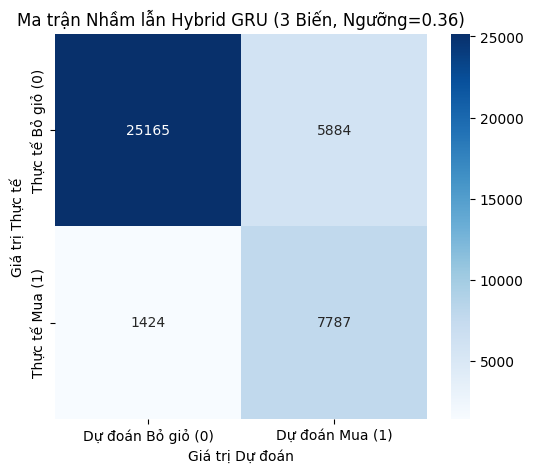


--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (3 BIẾN) ---


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
# THÊM fbeta_score vào import
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, fbeta_score 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- 1. KIỂM TRA ĐẦU VÀO ---
try:
    _ = X_seq_train
    _ = X_static_train
    _ = X_seq_val
    _ = X_static_val
    _ = X_seq_test
    _ = X_static_test
    _ = ACTION_MAPPING
except NameError:
    print("LỖI: Vui lòng chạy các khối Giai đoạn 1 (Preprocessing) trước.")
    raise

# --- 2. XỬ LÝ DỮ LIỆU TĨNH VÀ HẰNG SỐ ---

# *************************************************************
# *** ĐIỀU CHỈNH: CẮT LÁT DỮ LIỆU CHỈ LẤY 3 BIẾN GỐC ***
# *************************************************************
N_STATIC_FEATURES_BASELINE = 3 

# Cắt lát 3 cột đầu tiên từ dữ liệu tĩnh
X_static_train_3 = X_static_train[:, :N_STATIC_FEATURES_BASELINE]
X_static_val_3 = X_static_val[:, :N_STATIC_FEATURES_BASELINE]
X_static_test_3 = X_static_test[:, :N_STATIC_FEATURES_BASELINE]

# Cập nhật hằng số sử dụng kích thước mới
N_STATIC_FEATURES = N_STATIC_FEATURES_BASELINE 
GRU_UNITS = 30
LOSS_FUNCTION = 'binary_crossentropy'
EPOCHS = 10
DROPOUT_RATE = 0.0
BETA = 2 # Dùng cho việc tính F-beta Score cuối cùng

OPTIMAL_LR = best_params.get('learning_rate')
OPTIMAL_BS = best_params.get('batch_size')
OPTIMAL_EMBEDDING_DIM = best_params.get('embedding_dim')
OPTIMAL_DENSE_UNITS = best_params.get('dense_units')

VOCAB_SIZE = len(ACTION_MAPPING) + 1
MAX_SESSION_LENGTH = 30


print(f"\n--- SỬ DỤNG CÁC THAM SỐ TỐI ƯU ---")
print(f"  Số đặc trưng tĩnh đang sử dụng: {N_STATIC_FEATURES}")


# --- 3. ĐỊNH NGHĨA LẠI CÁC HÀM HỖ TRỢ ---

def build_hybrid_gru_model(learning_rate, emb_dim, dense_units):
    """
    Xây dựng kiến trúc Hybrid GRU, sử dụng N_STATIC_FEATURES = 3.
    """
    seq_input = Input(shape=(MAX_SESSION_LENGTH,), name='seq_input')
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=emb_dim, 
                    input_length=MAX_SESSION_LENGTH,
                    mask_zero=True)(seq_input)
    rnn_layer = GRU(GRU_UNITS, dropout=DROPOUT_RATE, name='gru_layer')(emb)
    # Kích thước Input cho Static Features đã được cập nhật thành 3
    static_input = Input(shape=(N_STATIC_FEATURES,), name='static_input') 
    combined_features = Concatenate(name='concatenate')([rnn_layer, static_input])
    
    hidden_layer_output = Dense(dense_units, activation='relu', name='hidden_dense')(combined_features) 
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer_output)
    
    model = Model(inputs=[seq_input, static_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=LOSS_FUNCTION,
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall')])
    return model

def find_best_threshold_on_training(model, X_seq_train, X_static_train, y_train):
    """
    Thực hiện "threshold analysis... on the training dataset" (Phần 5.4).
    Mục tiêu: Tối đa hóa F1 Score (theo bài báo gốc).
    """
    print(f"\n--- (Quy trình) Tìm Ngưỡng F1 (trên 60% Train) ---")
    start_thresh = time.time()
    # SỬ DỤNG DỮ LIỆU TĨNH ĐÃ CẮT LÁT (X_static_train)
    y_pred_proba_train = model.predict([X_seq_train, X_static_train]) 
    best_threshold = 0.5
    best_f1 = 0
    thresholds = np.arange(0.01, 1.0, 0.01)
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba_train > threshold).astype(int)
        f1 = f1_score(y_train, y_pred_binary)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    print(f"  Đã tìm thấy Ngưỡng Tốt Nhất: {best_threshold:.2f} (với F1={best_f1:.4f} trên tập Train)")
    print(f"  (Thời gian tìm ngưỡng: {time.time() - start_thresh:.2f} giây)")
    return best_threshold

# --- 4. THỰC HIỆN QUY TRÌNH HUẤN LUYỆN 80/20 CỦA BÀI BÁO ---

start_total_time = time.time()

# --- Bước A: Huấn luyện mô hình TẠM THỜI (trên 60% Train)
model_for_threshold = build_hybrid_gru_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)
model_for_threshold.fit(
    [X_seq_train, X_static_train_3], y_train, # SỬ DỤNG X_static_train_3
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    validation_data=([X_seq_val, X_static_val_3], y_val), # SỬ DỤNG X_static_val_3
    verbose=1
)

# --- Bước B: Tìm Ngưỡng (trên 60% Train)
best_threshold = find_best_threshold_on_training(
    model_for_threshold,
    X_seq_train,
    X_static_train_3, # SỬ DỤNG X_static_train_3
    y_train
)
del model_for_threshold 

# --- Bước C: Gộp Dữ liệu (Tạo tập 80%)
print("\n--- (Quy trình) Gộp Dữ liệu (Tạo tập 80%) ---")
X_seq_final_train = np.concatenate((X_seq_train, X_seq_val), axis=0)
X_static_final_train_3 = np.concatenate((X_static_train_3, X_static_val_3), axis=0) # GỘP DỮ LIỆU 3 BIẾN
y_final_train = np.concatenate((y_train, y_val), axis=0)

# --- Bước D: Huấn luyện mô hình CUỐI CÙNG (trên 80%)
print("\n--- (Quy trình) Huấn luyện mô hình CUỐI CÙNG (trên 80%) ---")
final_model = build_hybrid_gru_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)

final_model.fit(
    [X_seq_final_train, X_static_final_train_3], y_final_train, # SỬ DỤNG X_static_final_train_3
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    verbose=1 
)

# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test_3]) # SỬ DỤNG X_static_test_3

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# TÍNH TOÁN CÁC CHỈ SỐ
f1_baseline = f1_score(y_test, y_pred_test)
p_baseline = precision_score(y_test, y_pred_test)
r_baseline = recall_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
f2_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1)

cm_baseline = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID GRU (3 Biến, F1 Opt., Ngưỡng = {best_threshold:.2f}) ---")
print(f"  F1 Score (Test): {f1_baseline:.4f}")
print(f"  Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f"  F{BETA} Score (Test): {f2_score_test:.4f}")
print(f"  Precision (Test): {p_baseline:.4f}")
print(f"  Recall (Test): {r_baseline:.4f}")
print(f"  (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid GRU (3 Biến, Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (3 BIẾN) ---")


--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


--- KẾT QUẢ HYBRID GRU (3 Biến, F1 Opt., Ngưỡng = 0.36) ---
  F1 Score (Test): 0.6806
  Weighted F1 Score (Test): 0.8291
  F2 Score (Test): 0.7708
  Precision (Test): 0.5696
  Recall (Test): 0.8454
  (Tổng thời gian chạy: 28.24 phút)

Ma trận Nhầm lẫn (Confusion Matrix) trên Tập Test:


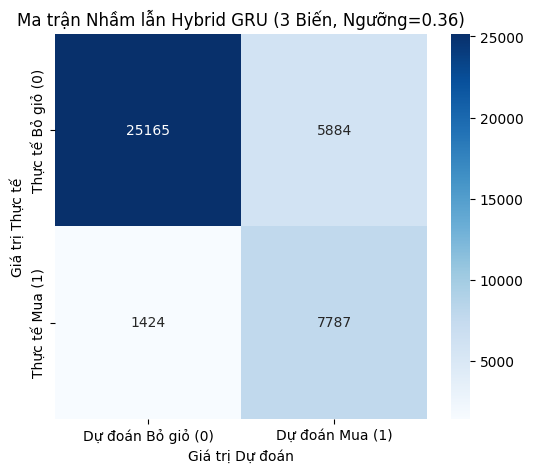


--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (3 BIẾN) ---


In [23]:
# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test_3]) # SỬ DỤNG X_static_test_3

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# TÍNH TOÁN CÁC CHỈ SỐ
f1_baseline = f1_score(y_test, y_pred_test)
p_baseline = precision_score(y_test, y_pred_test)
r_baseline = recall_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
f2_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1)

cm_baseline = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID GRU (3 Biến, F1 Opt., Ngưỡng = {best_threshold:.2f}) ---")
print(f"  F1 Score (Test): {f1_baseline:.4f}")
print(f"  Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f"  F{BETA} Score (Test): {f2_score_test:.4f}")
print(f"  Precision (Test): {p_baseline:.4f}")
print(f"  Recall (Test): {r_baseline:.4f}")
print(f"  (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid GRU (3 Biến, Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (3 BIẾN) ---")


--- THÔNG TIN HUẤN LUYỆN HYBRID LSTM (3 Biến Gốc) ---
  Số đặc trưng tĩnh đang sử dụng: 3
Epoch 1/10


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3775/3775 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - accuracy: 0.7852 - loss: 0.4091 - precision: 0.5640 - recall: 0.2699 - val_accuracy: 0.7908 - val_loss: 0.3997 - val_precision: 0.5697 - val_recall: 0.3505
Epoch 2/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 68s 18ms/step - accuracy: 0.7907 - loss: 0.3956 - precision: 0.5799 - recall: 0.3100 - val_accuracy: 0.7847 - val_loss: 0.4290 - val_precision: 0.5908 - val_recall: 0.1928
Epoch 3/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 69s 18ms/step - accuracy: 0.7941 - loss: 0.3891 - precision: 0.5913 - recall: 0.3235 - val_accuracy: 0.7944 - val_loss: 0.3926 - val_precision: 0.6230 - val_recall: 0.2567
Epoch 4/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 67s 18ms/step - accuracy: 0.7981 - loss: 0.3846 - precision: 0.6043 - recall: 0.3403 - val_accuracy: 0.8008 - val_loss: 0.3812 - val_precision: 0.6253 - val_recall: 0.3225
Epoch 5/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 77s 20ms/step - accuracy: 0.8004 - loss: 0.3812 - precision: 0.6114 - recall: 0.3502 - val_accuracy: 0.8021 - val

C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5033/5033 ━━━━━━━━━━━━━━━━━━━━ 101s 19ms/step - accuracy: 0.7881 - loss: 0.4044 - precision: 0.5726 - recall: 0.2915
Epoch 2/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 107s 21ms/step - accuracy: 0.7942 - loss: 0.3909 - precision: 0.5878 - recall: 0.3361
Epoch 3/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 95s 19ms/step - accuracy: 0.8028 - loss: 0.3805 - precision: 0.6183 - recall: 0.3611
Epoch 4/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 104s 21ms/step - accuracy: 0.8222 - loss: 0.3578 - precision: 0.6782 - recall: 0.4241
Epoch 5/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 114s 23ms/step - accuracy: 0.8672 - loss: 0.2831 - precision: 0.8054 - recall: 0.5533
Epoch 6/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 118s 23ms/step - accuracy: 0.8873 - loss: 0.2305 - precision: 0.8477 - recall: 0.6186
Epoch 7/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 111s 22ms/step - accuracy: 0.8907 - loss: 0.2181 - precision: 0.8793 - recall: 0.6056
Epoch 8/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.8921 - loss: 0.2149 - precision: 0.8715 - rec

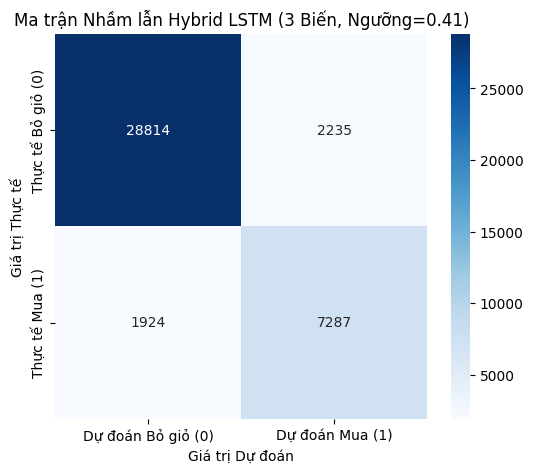


--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (3 BIẾN) ---


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
# Thêm lớp LSTM vào import
from tensorflow.keras.layers import Input, Embedding, GRU, LSTM, Dense, Concatenate 
from tensorflow.keras.optimizers import Adam
# THÊM fbeta_score vào import
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, fbeta_score 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- 1. KIỂM TRA ĐẦU VÀO ---
try:
    _ = X_seq_train
    _ = X_static_train
    _ = X_seq_val
    _ = X_static_val
    _ = X_seq_test
    _ = X_static_test
    _ = best_params
    _ = ACTION_MAPPING
except NameError:
    print("LỖI: Vui lòng chạy các khối Preprocessing (Giai đoạn 1) và Grid Search (Giai đoạn 2) trước.")
    raise

# --- 2. XỬ LÝ DỮ LIỆU TĨNH VÀ HẰNG SỐ ---

# *************************************************************
# *** ĐIỀU CHỈNH: CẮT LÁT DỮ LIỆU CHỈ LẤY 3 BIẾN GỐC ***
# *************************************************************
N_STATIC_FEATURES_BASELINE = 3 

# Cắt lát 3 cột đầu tiên từ dữ liệu tĩnh
X_static_train_3 = X_static_train[:, :N_STATIC_FEATURES_BASELINE]
X_static_val_3 = X_static_val[:, :N_STATIC_FEATURES_BASELINE]
X_static_test_3 = X_static_test[:, :N_STATIC_FEATURES_BASELINE]

# Cập nhật hằng số sử dụng kích thước mới
N_STATIC_FEATURES = N_STATIC_FEATURES_BASELINE 
RNN_UNITS = 30 # LSTM Units
LOSS_FUNCTION = 'binary_crossentropy'
EPOCHS = 10
DROPOUT_RATE = 0.0
BETA = 2 # Dùng cho việc tính F-beta Score cuối cùng

OPTIMAL_LR = best_params.get('learning_rate')
OPTIMAL_BS = best_params.get('batch_size')
OPTIMAL_EMBEDDING_DIM = best_params.get('embedding_dim')
OPTIMAL_DENSE_UNITS = best_params.get('dense_units')

VOCAB_SIZE = len(ACTION_MAPPING) + 1
MAX_SESSION_LENGTH = 30


print(f"\n--- THÔNG TIN HUẤN LUYỆN HYBRID LSTM (3 Biến Gốc) ---")
print(f"  Số đặc trưng tĩnh đang sử dụng: {N_STATIC_FEATURES}")


# --- 3. ĐỊNH NGHĨA HÀM XÂY DỰNG MÔ HÌNH LSTM ---

def build_hybrid_lstm_model(learning_rate, emb_dim, dense_units):
    """
    Xây dựng kiến trúc Hybrid LSTM, sử dụng N_STATIC_FEATURES = 3.
    """
    seq_input = Input(shape=(MAX_SESSION_LENGTH,), name='seq_input')
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=emb_dim, 
                    input_length=MAX_SESSION_LENGTH,
                    mask_zero=True)(seq_input)
    # *** SỬ DỤNG LỚP LSTM ***
    rnn_layer = LSTM(RNN_UNITS, dropout=DROPOUT_RATE, name='lstm_layer')(emb)
    
    # Đầu vào 2: Đặc trưng Tĩnh (3 Biến)
    static_input = Input(shape=(N_STATIC_FEATURES,), name='static_input') 
    
    combined_features = Concatenate(name='concatenate')([rnn_layer, static_input])
    
    hidden_layer_output = Dense(dense_units, activation='relu', name='hidden_dense')(combined_features) 
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer_output)
    
    model = Model(inputs=[seq_input, static_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=LOSS_FUNCTION,
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall')])
    return model

def find_best_threshold_on_training(model, X_seq_train, X_static_train, y_train):
    """
    Thực hiện tìm kiếm ngưỡng F1 tối ưu trên tập Train (60%) theo phương pháp gốc.
    """
    print(f"\n--- (Quy trình) Tìm Ngưỡng F1 (trên 60% Train) ---")
    start_thresh = time.time()
    # SỬ DỤNG DỮ LIỆU TĨNH ĐÃ CẮT LÁT (X_static_train)
    y_pred_proba_train = model.predict([X_seq_train, X_static_train])
    best_threshold = 0.5
    best_f1 = 0
    thresholds = np.arange(0.01, 1.0, 0.01)
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba_train > threshold).astype(int)
        f1 = f1_score(y_train, y_pred_binary)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    print(f"  Đã tìm thấy Ngưỡng Tốt Nhất: {best_threshold:.2f} (với F1={best_f1:.4f} trên tập Train)")
    print(f"  (Thời gian tìm ngưỡng: {time.time() - start_thresh:.2f} giây)")
    return best_threshold

# --- 4. THỰC HIỆN QUY TRÌNH HUẤN LUYỆN 80/20 CỦA BÀI BÁO ---

start_total_time = time.time()

# --- Bước A: Huấn luyện mô hình TẠM THỜI (trên 60% Train)
model_for_threshold = build_hybrid_lstm_model( # SỬ DỤNG HÀM LSTM
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)
model_for_threshold.fit(
    [X_seq_train, X_static_train_3], y_train, # SỬ DỤNG X_static_train_3
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    validation_data=([X_seq_val, X_static_val_3], y_val), # SỬ DỤNG X_static_val_3
    verbose=1
)

# --- Bước B: Tìm Ngưỡng (trên 60% Train)
best_threshold = find_best_threshold_on_training(
    model_for_threshold,
    X_seq_train,
    X_static_train_3, # SỬ DỤNG X_static_train_3
    y_train
)
del model_for_threshold 

# --- Bước C: Gộp Dữ liệu (Tạo tập 80%)
print("\n--- (Quy trình) Gộp Dữ liệu (Tạo tập 80%) ---")
X_seq_final_train = np.concatenate((X_seq_train, X_seq_val), axis=0)
X_static_final_train_3 = np.concatenate((X_static_train_3, X_static_val_3), axis=0) # GỘP DỮ LIỆU 3 BIẾN
y_final_train = np.concatenate((y_train, y_val), axis=0)

# --- Bước D: Huấn luyện mô hình CUỐI CÙNG (trên 80%)
print("\n--- (Quy trình) Huấn luyện mô hình LSTM CUỐI CÙNG (trên 80%) ---")
final_model = build_hybrid_lstm_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)

final_model.fit(
    [X_seq_final_train, X_static_final_train_3], y_final_train, # SỬ DỤNG X_static_final_train_3
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    verbose=1 
)

# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test_3]) # SỬ DỤNG X_static_test_3

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# TÍNH TOÁN CÁC CHỈ SỐ
f1_baseline = f1_score(y_test, y_pred_test)
p_baseline = precision_score(y_test, y_pred_test)
r_baseline = recall_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
fbeta_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1)

cm_baseline = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID LSTM (3 Biến, F1 Opt., Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_baseline:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f" F{BETA} Score (Test): {fbeta_score_test:.4f}")
print(f" Precision (Test): {p_baseline:.4f}")
print(f" Recall (Test): {r_baseline:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid LSTM (3 Biến, Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (3 BIẾN) ---")


--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


--- KẾT QUẢ HYBRID LSTM (3 Biến, F1 Opt., Ngưỡng = 0.41) ---
 F1 Score (Test): 0.7780
 Weighted F1 Score (Test): 0.8973
 F2 Score (Test): 0.7858
 Precision (Test): 0.7653
 Recall (Test): 0.7911
 (Tổng thời gian chạy: 33.81 phút)

Ma trận Nhầm lẫn (Confusion Matrix) trên Tập Test:


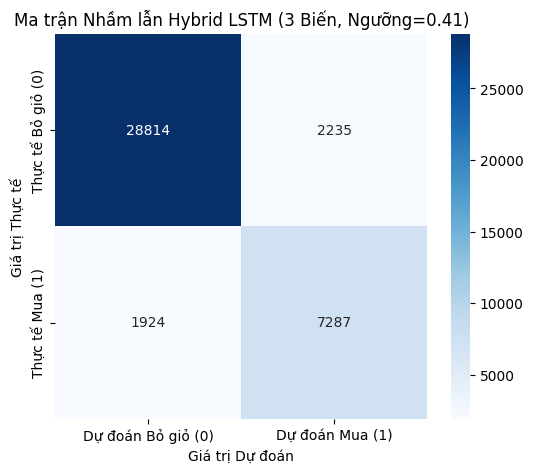


--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (3 BIẾN) ---


In [25]:
# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test_3]) # SỬ DỤNG X_static_test_3

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# TÍNH TOÁN CÁC CHỈ SỐ
f1_baseline = f1_score(y_test, y_pred_test)
p_baseline = precision_score(y_test, y_pred_test)
r_baseline = recall_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
fbeta_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1)

cm_baseline = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID LSTM (3 Biến, F1 Opt., Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_baseline:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f" F{BETA} Score (Test): {fbeta_score_test:.4f}")
print(f" Precision (Test): {p_baseline:.4f}")
print(f" Recall (Test): {r_baseline:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid LSTM (3 Biến, Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (3 BIẾN) ---")


--- THÔNG TIN HUẤN LUYỆN HYBRID GRU (3 Biến Gốc, F2 Optimization) ---
  Số đặc trưng tĩnh đang sử dụng: 3

--- (Quy trình) Huấn luyện mô hình TẠM THỜI (trên 60% Train) ---
Epoch 1/10


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3775/3775 ━━━━━━━━━━━━━━━━━━━━ 78s 20ms/step - accuracy: 0.7851 - loss: 0.4088 - precision: 0.5618 - recall: 0.2757 - val_accuracy: 0.7869 - val_loss: 0.4056 - val_precision: 0.5452 - val_recall: 0.4148
Epoch 2/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 92s 24ms/step - accuracy: 0.7951 - loss: 0.3915 - precision: 0.5929 - recall: 0.3341 - val_accuracy: 0.8003 - val_loss: 0.3842 - val_precision: 0.6247 - val_recall: 0.3186
Epoch 3/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 98s 26ms/step - accuracy: 0.7994 - loss: 0.3847 - precision: 0.6047 - recall: 0.3563 - val_accuracy: 0.7878 - val_loss: 0.4056 - val_precision: 0.6510 - val_recall: 0.1568
Epoch 4/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 85s 22ms/step - accuracy: 0.8015 - loss: 0.3862 - precision: 0.6161 - recall: 0.3509 - val_accuracy: 0.7807 - val_loss: 0.4192 - val_precision: 0.5527 - val_recall: 0.2174
Epoch 5/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 96s 25ms/step - accuracy: 0.7889 - loss: 0.4040 - precision: 0.5753 - recall: 0.2958 - val_accuracy: 0.7952 - val

C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5033/5033 ━━━━━━━━━━━━━━━━━━━━ 126s 24ms/step - accuracy: 0.7875 - loss: 0.4059 - precision: 0.5693 - recall: 0.2926
Epoch 2/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 126s 25ms/step - accuracy: 0.7963 - loss: 0.3899 - precision: 0.5999 - recall: 0.3291
Epoch 3/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 124s 25ms/step - accuracy: 0.8030 - loss: 0.3807 - precision: 0.6159 - recall: 0.3696
Epoch 4/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 133s 26ms/step - accuracy: 0.8154 - loss: 0.3674 - precision: 0.6430 - recall: 0.4341
Epoch 5/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 149s 30ms/step - accuracy: 0.8090 - loss: 0.3793 - precision: 0.6350 - recall: 0.3890
Epoch 6/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 126s 25ms/step - accuracy: 0.8137 - loss: 0.3704 - precision: 0.6383 - recall: 0.4288
Epoch 7/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 130s 26ms/step - accuracy: 0.8641 - loss: 0.2911 - precision: 0.7550 - recall: 0.6010
Epoch 8/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 128s 25ms/step - accuracy: 0.8862 - loss: 0.2412 - precision: 0.8056 - re

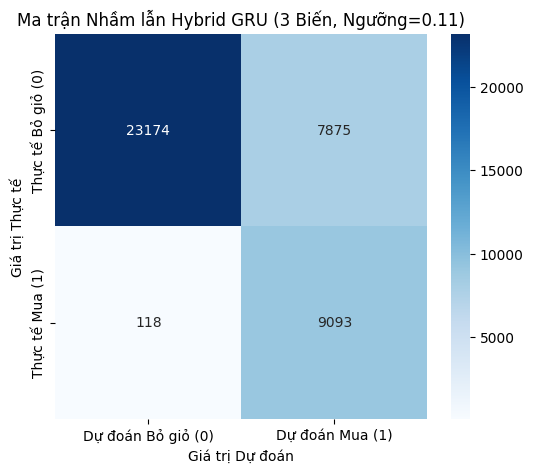


--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (3 BIẾN, MAX F-BETA) ---


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
# THÊM fbeta_score vào import
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, fbeta_score 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- 1. KIỂM TRA ĐẦU VÀO ---
try:
    _ = X_seq_train
    _ = X_static_train
    _ = X_seq_val
    _ = X_static_val
    _ = X_seq_test
    _ = X_static_test
    _ = best_params
    _ = ACTION_MAPPING
except NameError:
    print("LỖI: Vui lòng chạy các khối Preprocessing (Giai đoạn 1) và Grid Search (Giai đoạn 2) trước.")
    raise

# --- 2. XỬ LÝ DỮ LIỆU TĨNH VÀ HẰNG SỐ ---

# *************************************************************
# *** ĐIỀU CHỈNH: CẮT LÁT DỮ LIỆU CHỈ LẤY 3 BIẾN GỐC ***
# *************************************************************
N_STATIC_FEATURES_BASELINE = 3 

# Cắt lát 3 cột đầu tiên từ dữ liệu tĩnh
X_static_train_3 = X_static_train[:, :N_STATIC_FEATURES_BASELINE]
X_static_val_3 = X_static_val[:, :N_STATIC_FEATURES_BASELINE]
X_static_test_3 = X_static_test[:, :N_STATIC_FEATURES_BASELINE]

# Cập nhật hằng số sử dụng kích thước mới (3)
N_STATIC_FEATURES = N_STATIC_FEATURES_BASELINE 
GRU_UNITS = 30
LOSS_FUNCTION = 'binary_crossentropy'
EPOCHS = 10
DROPOUT_RATE = 0.0
BETA = 2 # Mục tiêu tối ưu hóa F-beta (F2 Score)

OPTIMAL_LR = best_params.get('learning_rate')
OPTIMAL_BS = best_params.get('batch_size')
OPTIMAL_EMBEDDING_DIM = best_params.get('embedding_dim')
OPTIMAL_DENSE_UNITS = best_params.get('dense_units')

VOCAB_SIZE = len(ACTION_MAPPING) + 1
MAX_SESSION_LENGTH = 30


print(f"\n--- THÔNG TIN HUẤN LUYỆN HYBRID GRU (3 Biến Gốc, F{BETA} Optimization) ---")
print(f"  Số đặc trưng tĩnh đang sử dụng: {N_STATIC_FEATURES}")


# --- 3. ĐỊNH NGHĨA HÀM XÂY DỰNG MÔ HÌNH GRU ---

def build_hybrid_gru_model(learning_rate, emb_dim, dense_units):
    """
    Xây dựng kiến trúc Hybrid GRU, sử dụng N_STATIC_FEATURES = 3.
    """
    seq_input = Input(shape=(MAX_SESSION_LENGTH,), name='seq_input')
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=emb_dim, 
                    input_length=MAX_SESSION_LENGTH,
                    mask_zero=True)(seq_input)
    rnn_layer = GRU(GRU_UNITS, dropout=DROPOUT_RATE, name='gru_layer')(emb)
    
    # Đầu vào 2: Đặc trưng Tĩnh (N_STATIC_FEATURES = 3)
    static_input = Input(shape=(N_STATIC_FEATURES,), name='static_input')
    
    combined_features = Concatenate(name='concatenate')([rnn_layer, static_input])
    
    hidden_layer_output = Dense(dense_units, activation='relu', name='hidden_dense')(combined_features) 
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer_output)
    
    model = Model(inputs=[seq_input, static_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=LOSS_FUNCTION,
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall')])
    return model

# --- HÀM TÌM NGƯỠNG CẢI TIẾN: MAX F-BETA TRÊN TẬP VALIDATION ---

def find_best_threshold_on_validation(model, X_seq_val, X_static_val, y_val, beta=BETA):
    """
    Thực hiện phân tích ngưỡng F-beta tối ưu (beta=2) trên Tập Validation (20%).
    """
    print(f"\n--- (Quy trình) Tìm Ngưỡng Max F{beta} (trên 20% Validation) ---")
    start_thresh = time.time()
    
    # 1. Dự đoán trên TẬP VALIDATION
    # X_static_val đã được cắt lát thành 3 cột bên ngoài hàm này
    y_pred_proba_val = model.predict([X_seq_val, X_static_val]) 
    best_threshold = 0.5
    best_fbeta = 0
    
    thresholds = np.arange(0.01, 1.0, 0.01)
    
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba_val > threshold).astype(int)
        
        # 2. SỬ DỤNG F-BETA SCORE LÀM TIÊU CHÍ TỐI ƯU
        fbeta_score_val = fbeta_score(y_val, y_pred_binary, beta=beta, pos_label=1)
        
        if fbeta_score_val > best_fbeta:
            best_fbeta = fbeta_score_val
            best_threshold = threshold
            
    print(f"  Đã tìm thấy Ngưỡng Tốt Nhất: {best_threshold:.2f} (với F{beta}={best_fbeta:.4f} trên tập Validation)")
    print(f"  (Thời gian tìm ngưỡng: {time.time() - start_thresh:.2f} giây)")
    return best_threshold

# --- 4. THỰC HIỆN QUY TRÌNH HUẤN LUYỆN 80/20 ---

start_total_time = time.time()

# --- Bước A: Huấn luyện mô hình TẠM THỜI (trên 60% Train) để tìm ngưỡng
print("\n--- (Quy trình) Huấn luyện mô hình TẠM THỜI (trên 60% Train) ---")
model_for_threshold = build_hybrid_gru_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)
model_for_threshold.fit(
    [X_seq_train, X_static_train_3], y_train, # SỬ DỤNG X_static_train_3
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    validation_data=([X_seq_val, X_static_val_3], y_val), # SỬ DỤNG X_static_val_3
    verbose=1
)

# --- Bước B: Tìm Ngưỡng Max F-beta Tối ưu (trên Validation)
best_threshold = find_best_threshold_on_validation(
    model_for_threshold,
    X_seq_val,         
    X_static_val_3,      # SỬ DỤNG X_static_val_3
    y_val              
)
del model_for_threshold # Giải phóng bộ nhớ

# --- Bước C: Gộp Dữ liệu (Tạo tập 80%)
print("\n--- (Quy trình) Gộp Dữ liệu (Tạo tập 80%) ---")
X_seq_final_train = np.concatenate((X_seq_train, X_seq_val), axis=0)
X_static_final_train_3 = np.concatenate((X_static_train_3, X_static_val_3), axis=0) # GỘP DỮ LIỆU 3 BIẾN
y_final_train = np.concatenate((y_train, y_val), axis=0)

# --- Bước D: Huấn luyện mô hình CUỐI CÙNG (trên 80%)
print("\n--- (Quy trình) Huấn luyện mô hình CUỐI CÙNG (trên 80%) ---")
final_model = build_hybrid_gru_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)

final_model.fit(
    [X_seq_final_train, X_static_final_train_3], y_final_train, # SỬ DỤNG X_static_final_train_3
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    verbose=1 
)

# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test_3]) # SỬ DỤNG X_static_test_3

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
fbeta_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1)
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID GRU (3 Biến Gốc, Max F{BETA} Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f" F{BETA} Score (Test): {fbeta_score_test:.4f}")
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid GRU (3 Biến, Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (3 BIẾN, MAX F-BETA) ---")


--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


--- KẾT QUẢ HYBRID GRU (3 Biến Gốc, Max F2 Ngưỡng = 0.11) ---
 F1 Score (Test): 0.6947
 Weighted F1 Score (Test): 0.8167
 F2 Score (Test): 0.8449
 Precision (Test): 0.5359
 Recall (Test): 0.9872
 (Tổng thời gian chạy: 36.66 phút)

Ma trận Nhầm lẫn (Confusion Matrix) trên Tập Test:


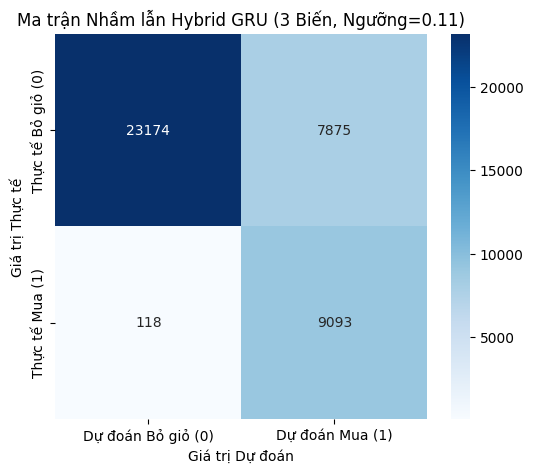


--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (3 BIẾN, MAX F-BETA) ---


In [27]:
# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test_3]) # SỬ DỤNG X_static_test_3

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
fbeta_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1)
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID GRU (3 Biến Gốc, Max F{BETA} Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f" F{BETA} Score (Test): {fbeta_score_test:.4f}")
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid GRU (3 Biến, Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (3 BIẾN, MAX F-BETA) ---")


--- THÔNG TIN HUẤN LUYỆN HYBRID LSTM (3 Đặc trưng Gốc) ---
 Số đặc trưng tĩnh đang sử dụng: 3
 Mục tiêu tối ưu ngưỡng: Max F2 Score

--- (Quy trình) Huấn luyện mô hình TẠM THỜI (trên 60% Train) ---
Epoch 1/10


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3775/3775 ━━━━━━━━━━━━━━━━━━━━ 69s 18ms/step - accuracy: 0.7841 - loss: 0.4108 - precision: 0.5580 - recall: 0.2716 - val_accuracy: 0.7866 - val_loss: 0.4014 - val_precision: 0.5450 - val_recall: 0.4078
Epoch 2/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 84s 22ms/step - accuracy: 0.7908 - loss: 0.3977 - precision: 0.5816 - recall: 0.3054 - val_accuracy: 0.7923 - val_loss: 0.3931 - val_precision: 0.6246 - val_recall: 0.2310
Epoch 3/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 86s 23ms/step - accuracy: 0.7947 - loss: 0.3910 - precision: 0.5918 - recall: 0.3315 - val_accuracy: 0.7894 - val_loss: 0.3932 - val_precision: 0.6251 - val_recall: 0.1993
Epoch 4/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.7978 - loss: 0.3875 - precision: 0.5998 - recall: 0.3499 - val_accuracy: 0.7940 - val_loss: 0.3927 - val_precision: 0.5537 - val_recall: 0.5145
Epoch 5/10
3775/3775 ━━━━━━━━━━━━━━━━━━━━ 75s 20ms/step - accuracy: 0.8057 - loss: 0.3797 - precision: 0.6205 - recall: 0.3878 - val_accuracy: 0.7874 - val

C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5033/5033 ━━━━━━━━━━━━━━━━━━━━ 139s 23ms/step - accuracy: 0.7850 - loss: 0.4090 - precision: 0.5663 - recall: 0.2572
Epoch 2/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.7921 - loss: 0.3931 - precision: 0.5873 - recall: 0.3076
Epoch 3/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 95s 19ms/step - accuracy: 0.7943 - loss: 0.3895 - precision: 0.5908 - recall: 0.3280
Epoch 4/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 120s 24ms/step - accuracy: 0.7991 - loss: 0.3841 - precision: 0.6093 - recall: 0.3399
Epoch 5/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 108s 21ms/step - accuracy: 0.8145 - loss: 0.3677 - precision: 0.6586 - recall: 0.3926
Epoch 6/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 124s 25ms/step - accuracy: 0.8373 - loss: 0.3336 - precision: 0.7293 - recall: 0.4595
Epoch 7/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 122s 24ms/step - accuracy: 0.8595 - loss: 0.2895 - precision: 0.7850 - recall: 0.5313
Epoch 8/10
5033/5033 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.8676 - loss: 0.2646 - precision: 0.8078 - rec

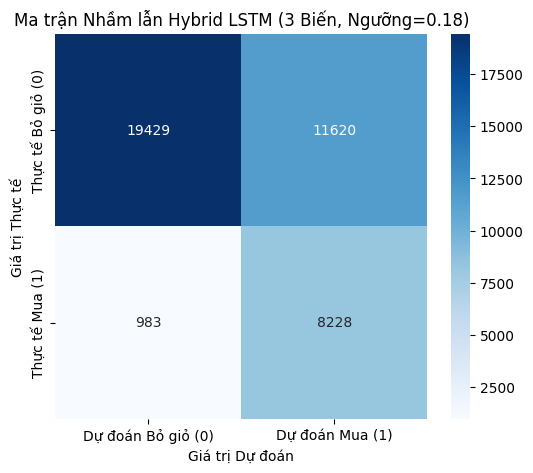


--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (MAX F-BETA, 3 BIẾN) ---


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate # Sử dụng LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, fbeta_score 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- 1. KIỂM TRA ĐẦU VÀO ---
try:
    _ = X_seq_train
    _ = X_static_train
    _ = X_seq_val
    _ = X_static_val
    _ = best_params
    _ = ACTION_MAPPING
except NameError:
    print("LỖI: Vui lòng chạy các khối Preprocessing (Giai đoạn 1) và Grid Search (Giai đoạn 2) trước.")
    raise

# --- 2. XỬ LÝ DỮ LIỆU TĨNH VÀ HẰNG SỐ ---

# *************************************************************
# *** ĐIỀU CHỈNH: CẮT LÁT DỮ LIỆU CHỈ LẤY 3 BIẾN GỐC ***
# *************************************************************
N_STATIC_FEATURES_BASELINE = 3 

# Cắt lát 3 cột đầu tiên từ dữ liệu tĩnh
X_static_train_3 = X_static_train[:, :N_STATIC_FEATURES_BASELINE]
X_static_val_3 = X_static_val[:, :N_STATIC_FEATURES_BASELINE]
X_static_test_3 = X_static_test[:, :N_STATIC_FEATURES_BASELINE] # Chuẩn bị cho bước E

# Lấy tham số tối ưu từ Grid Search
OPTIMAL_LR = best_params.get('learning_rate')
OPTIMAL_BS = best_params.get('batch_size')
OPTIMAL_EMBEDDING_DIM = best_params.get('embedding_dim')
OPTIMAL_DENSE_UNITS = best_params.get('dense_units')

# Các hằng số kiến trúc
VOCAB_SIZE = len(ACTION_MAPPING) + 1
MAX_SESSION_LENGTH = 30
RNN_UNITS = 30 # LSTM Units
LOSS_FUNCTION = 'binary_crossentropy'
EPOCHS = 10
DROPOUT_RATE = 0.0
BETA = 2 # Mục tiêu tối ưu hóa F-beta (F2 Score)


print(f"\n--- THÔNG TIN HUẤN LUYỆN HYBRID LSTM (3 Đặc trưng Gốc) ---")
print(f" Số đặc trưng tĩnh đang sử dụng: {N_STATIC_FEATURES_BASELINE}")
print(f" Mục tiêu tối ưu ngưỡng: Max F{BETA} Score")


# --- 3. ĐỊNH NGHĨA HÀM XÂY DỰNG MÔ HÌNH LSTM ---

def build_hybrid_lstm_model(learning_rate, emb_dim, dense_units):
    """
    Xây dựng kiến trúc Hybrid LSTM (3 Biến).
    """
    # Đầu vào 1: Chuỗi
    seq_input = Input(shape=(MAX_SESSION_LENGTH,), name='seq_input')
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=emb_dim, 
                    input_length=MAX_SESSION_LENGTH,
                    mask_zero=True)(seq_input)
    # *** SỬ DỤNG LỚP LSTM ***
    rnn_layer = LSTM(RNN_UNITS, dropout=DROPOUT_RATE, name='lstm_layer')(emb)
    
    # Đầu vào 2: Đặc trưng Tĩnh (3 Biến)
    static_input = Input(shape=(N_STATIC_FEATURES_BASELINE,), name='static_input')
    
    # Kết hợp các đặc trưng
    combined_features = Concatenate(name='concatenate')([rnn_layer, static_input])
    
    # Lớp ẩn và đầu ra
    hidden_layer_output = Dense(dense_units, activation='relu', name='hidden_dense')(combined_features) 
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer_output)
    
    model = Model(inputs=[seq_input, static_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=LOSS_FUNCTION,
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall')])
    return model

# --- HÀM TÌM NGƯỠNG CẢI TIẾN: MAX F-BETA TRÊN TẬP VALIDATION ---

def find_best_threshold_on_validation(model, X_seq_val, X_static_val, y_val, beta=BETA):
    """
    Thực hiện phân tích ngưỡng F-beta tối ưu (beta=2) trên Tập Validation (20%).
    """
    print(f"\n--- (Quy trình) Tìm Ngưỡng Max F{beta} (trên 20% Validation) ---")
    start_thresh = time.time()
    
    # 1. Dự đoán trên TẬP VALIDATION
    y_pred_proba_val = model.predict([X_seq_val, X_static_val])
    best_threshold = 0.5
    best_fbeta = 0
    
    thresholds = np.arange(0.01, 1.0, 0.01)
    
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba_val > threshold).astype(int)
        
        # 2. SỬ DỤNG F-BETA SCORE LÀM TIÊU CHÍ TỐI ƯU
        fbeta_score_val = fbeta_score(y_val, y_pred_binary, beta=beta, pos_label=1)
        
        if fbeta_score_val > best_fbeta:
            best_fbeta = fbeta_score_val
            best_threshold = threshold
            
    print(f" Đã tìm thấy Ngưỡng Tốt Nhất: {best_threshold:.2f} (với F{beta}={best_fbeta:.4f} trên tập Validation)")
    print(f" (Thời gian tìm ngưỡng: {time.time() - start_thresh:.2f} giây)")
    return best_threshold

# --- 4. THỰC HIỆN QUY TRÌNH HUẤN LUYỆN 80/20 ---

start_total_time = time.time()

# --- Bước A: Huấn luyện mô hình TẠM THỜI (trên 60% Train) để tìm ngưỡng
print("\n--- (Quy trình) Huấn luyện mô hình TẠM THỜI (trên 60% Train) ---")
model_for_threshold = build_hybrid_lstm_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)
model_for_threshold.fit(
    [X_seq_train, X_static_train_3], y_train, # SỬ DỤNG X_static_train_3
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    validation_data=([X_seq_val, X_static_val_3], y_val), # SỬ DỤNG X_static_val_3
    verbose=1
)

# --- Bước B: Tìm Ngưỡng Max F-beta Tối ưu (trên Validation)
best_threshold = find_best_threshold_on_validation(
    model_for_threshold,
    X_seq_val,         
    X_static_val_3,    # SỬ DỤNG X_static_val_3
    y_val              
)
del model_for_threshold # Giải phóng bộ nhớ

# --- Bước C: Gộp Dữ liệu (Tạo tập 80%)
print("\n--- (Quy trình) Gộp Dữ liệu (Tạo tập 80%) ---")
X_seq_final_train = np.concatenate((X_seq_train, X_seq_val), axis=0)
X_static_final_train_3 = np.concatenate((X_static_train_3, X_static_val_3), axis=0)
y_final_train = np.concatenate((y_train, y_val), axis=0)
print(f" Kích thước tập huấn luyện cuối cùng: {len(y_final_train)} mẫu")

# --- Bước D: Huấn luyện mô hình CUỐI CÙNG (trên 80%)
print("\n--- (Quy trình) Huấn luyện mô hình LSTM CUỐI CÙNG (trên 80%) ---")
final_model = build_hybrid_lstm_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)

final_model.fit(
    [X_seq_final_train, X_static_final_train_3], y_final_train, # SỬ DỤNG X_static_final_train_3
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    verbose=1 
)
print(" Huấn luyện mô hình cuối cùng hoàn tất.")

# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test_3]) # SỬ DỤNG X_static_test_3

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
fbeta_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1) # F2 Score
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID LSTM (3 Biến Gốc, Max F{BETA} Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f" F{BETA} Score (Test): {fbeta_score_test:.4f}")
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid LSTM (3 Biến, Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (MAX F-BETA, 3 BIẾN) ---")


--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


--- KẾT QUẢ HYBRID LSTM (3 Biến Gốc, Max F2 Ngưỡng = 0.18) ---
 F1 Score (Test): 0.5663
 Weighted F1 Score (Test): 0.7119
 F2 Score (Test): 0.7257
 Precision (Test): 0.4146
 Recall (Test): 0.8933
 (Tổng thời gian chạy: 35.26 phút)

Ma trận Nhầm lẫn (Confusion Matrix) trên Tập Test:


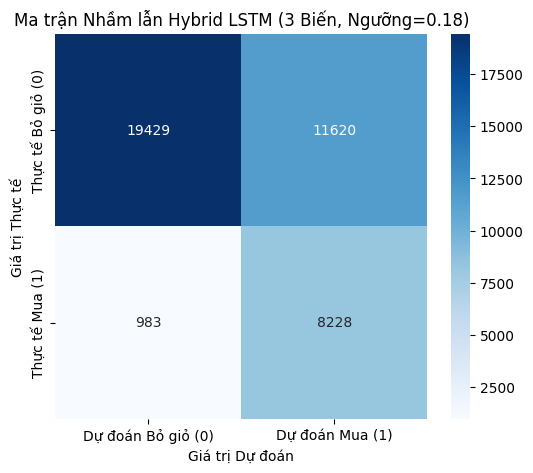


--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (MAX F-BETA, 3 BIẾN) ---


In [29]:
# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test_3]) # SỬ DỤNG X_static_test_3

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
fbeta_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1) # F2 Score
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID LSTM (3 Biến Gốc, Max F{BETA} Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f" F{BETA} Score (Test): {fbeta_score_test:.4f}")
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid LSTM (3 Biến, Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (MAX F-BETA, 3 BIẾN) ---")


--- THÔNG TIN HUẤN LUYỆN HYBRID GRU (7 Đặc trưng) ---
 Số đặc trưng tĩnh: 7
 Learning Rate: 0.01
 Batch Size: 64

--- (Quy trình) Huấn luyện mô hình TẠM THỜI (trên 60% Train) ---
Epoch 1/10


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1888/1888 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.8116 - loss: 0.3680 - precision: 0.6200 - recall: 0.4564 - val_accuracy: 0.8225 - val_loss: 0.3480 - val_precision: 0.7383 - val_recall: 0.3473
Epoch 2/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.8360 - loss: 0.3276 - precision: 0.6708 - recall: 0.5567 - val_accuracy: 0.8546 - val_loss: 0.3089 - val_precision: 0.7614 - val_recall: 0.5310
Epoch 3/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.8652 - loss: 0.2879 - precision: 0.7318 - recall: 0.6488 - val_accuracy: 0.8812 - val_loss: 0.2659 - val_precision: 0.7885 - val_recall: 0.6572
Epoch 4/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.8954 - loss: 0.2394 - precision: 0.8413 - recall: 0.6690 - val_accuracy: 0.9026 - val_loss: 0.2201 - val_precision: 0.8842 - val_recall: 0.6607
Epoch 5/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9110 - loss: 0.2022 - precision: 0.8794 - recall: 0.7082 - val_accuracy: 0.9167 - val

C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2517/2517 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.8137 - loss: 0.3649 - precision: 0.6256 - recall: 0.4624
Epoch 2/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.8419 - loss: 0.3222 - precision: 0.6940 - recall: 0.5524
Epoch 3/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.8798 - loss: 0.2675 - precision: 0.7882 - recall: 0.6488
Epoch 4/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.9087 - loss: 0.2133 - precision: 0.8506 - recall: 0.7290
Epoch 5/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.9150 - loss: 0.1866 - precision: 0.8651 - recall: 0.7448
Epoch 6/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.9190 - loss: 0.1730 - precision: 0.8879 - recall: 0.7395
Epoch 7/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.9201 - loss: 0.1664 - precision: 0.8833 - recall: 0.7502
Epoch 8/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.9208 - loss: 0.1623 - precision: 0.8771 - recall: 0.

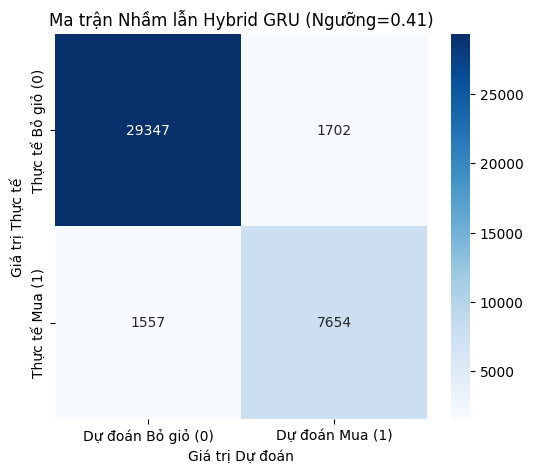


--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU CẢI TIẾN ---


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- 1. KIỂM TRA ĐẦU VÀO ---
# Kiểm tra các biến từ Giai đoạn 1 và 2 (Preprocessing và Grid Search)
try:
    _ = X_seq_train
    _ = X_static_train
    _ = X_seq_test
    _ = best_params
    _ = ACTION_MAPPING
except NameError:
    print("LỖI: Vui lòng chạy các khối Preprocessing (Giai đoạn 1) và Grid Search (Giai đoạn 2) trước.")
    raise

# --- 2. LẤY CÁC HẰNG SỐ TỐI ƯU VÀ KIẾN TRÚC ---

# Lấy tham số tối ưu từ Grid Search
OPTIMAL_LR = best_params.get('learning_rate')
OPTIMAL_BS = best_params.get('batch_size')
OPTIMAL_EMBEDDING_DIM = best_params.get('embedding_dim')
OPTIMAL_DENSE_UNITS = best_params.get('dense_units')

# Các hằng số kiến trúc (Đã được định nghĩa trong các khối trước)
VOCAB_SIZE = len(ACTION_MAPPING) + 1
MAX_SESSION_LENGTH = 30
GRU_UNITS = 30 # "approximately 30 neurons" [cite: 386]
LOSS_FUNCTION = 'binary_crossentropy' # "Binary cross-entropy" [cite: 387]
EPOCHS = 10 # "over ten epochs" [cite: 387]
DROPOUT_RATE = 0.0 # "all hybrid models performed best without introducing dropout" [cite: 401]

# *************************************************************
# *** ĐIỀU CHỈNH: CẬP NHẬT SỐ LƯỢNG ĐẶC TRƯNG TĨNH = 7 ***
# *************************************************************
N_STATIC_FEATURES = X_static_train.shape[1] 


print(f"\n--- THÔNG TIN HUẤN LUYỆN HYBRID GRU (7 Đặc trưng) ---")
print(f" Số đặc trưng tĩnh: {N_STATIC_FEATURES}")
print(f" Learning Rate: {OPTIMAL_LR}")
print(f" Batch Size: {OPTIMAL_BS}")


# --- 3. ĐỊNH NGHĨA HÀM XÂY DỰNG MÔ HÌNH GRU ---

def build_hybrid_gru_model(learning_rate, emb_dim, dense_units):
    """
    Xây dựng kiến trúc Hybrid GRU, chấp nhận N_STATIC_FEATURES đã cập nhật.
    """
    # Đầu vào 1: Chuỗi
    seq_input = Input(shape=(MAX_SESSION_LENGTH,), name='seq_input')
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=emb_dim, 
                    input_length=MAX_SESSION_LENGTH,
                    mask_zero=True)(seq_input)
    rnn_layer = GRU(GRU_UNITS, dropout=DROPOUT_RATE, name='gru_layer')(emb)
    
    # Đầu vào 2: Đặc trưng Tĩnh (N_STATIC_FEATURES = 7)
    static_input = Input(shape=(N_STATIC_FEATURES,), name='static_input')
    
    # Kết hợp các đặc trưng
    combined_features = Concatenate(name='concatenate')([rnn_layer, static_input])
    
    # Lớp ẩn và đầu ra
    hidden_layer_output = Dense(dense_units, activation='relu', name='hidden_dense')(combined_features) 
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer_output)
    
    model = Model(inputs=[seq_input, static_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=LOSS_FUNCTION,
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall')])
    return model

def find_best_threshold_on_training(model, X_seq_train, X_static_train, y_train):
    """
    Thực hiện phân tích ngưỡng F1 tối ưu trên tập Huấn luyện (60%).
    """
    print(f"\n--- (Quy trình) Tìm Ngưỡng F1 (trên 60% Train) ---")
    start_thresh = time.time()
    y_pred_proba_train = model.predict([X_seq_train, X_static_train])
    best_threshold = 0.5
    best_f1 = 0
    thresholds = np.arange(0.01, 1.0, 0.01)
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba_train > threshold).astype(int)
        f1 = f1_score(y_train, y_pred_binary)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    print(f" Đã tìm thấy Ngưỡng Tốt Nhất: {best_threshold:.2f} (với F1={best_f1:.4f} trên tập Train)")
    print(f" (Thời gian tìm ngưỡng: {time.time() - start_thresh:.2f} giây)")
    return best_threshold

# --- 4. THỰC HIỆN QUY TRÌNH HUẤN LUYỆN 80/20 ---

start_total_time = time.time()

# --- Bước A: Huấn luyện mô hình TẠM THỜI (trên 60% Train) để tìm ngưỡng
print("\n--- (Quy trình) Huấn luyện mô hình TẠM THỜI (trên 60% Train) ---")
model_for_threshold = build_hybrid_gru_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)
model_for_threshold.fit(
    [X_seq_train, X_static_train], y_train,
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    validation_data=([X_seq_val, X_static_val], y_val),
    verbose=1
)

# --- Bước B: Tìm Ngưỡng F1 Tối ưu (trên 60% Train)
best_threshold = find_best_threshold_on_training(
    model_for_threshold,
    X_seq_train,
    X_static_train,
    y_train
)
del model_for_threshold # Giải phóng bộ nhớ

# --- Bước C: Gộp Dữ liệu (Tạo tập 80%)
print("\n--- (Quy trình) Gộp Dữ liệu (Tạo tập 80%) ---")
X_seq_final_train = np.concatenate((X_seq_train, X_seq_val), axis=0)
X_static_final_train = np.concatenate((X_static_train, X_static_val), axis=0)
y_final_train = np.concatenate((y_train, y_val), axis=0)
print(f" Kích thước tập huấn luyện cuối cùng: {len(y_final_train)} mẫu")

# --- Bước D: Huấn luyện mô hình CUỐI CÙNG (trên 80%)
print("\n--- (Quy trình) Huấn luyện mô hình CUỐI CÙNG (trên 80%) ---")
final_model = build_hybrid_gru_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)

final_model.fit(
    [X_seq_final_train, X_static_final_train], y_final_train,
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    verbose=1 
)
print(" Huấn luyện mô hình cuối cùng hoàn tất.")

# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test])

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID GRU (7 Đặc trưng, Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid GRU (Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU CẢI TIẾN ---")


--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


--- KẾT QUẢ HYBRID GRU (7 Đặc trưng, Ngưỡng = 0.41) ---
 F1 Score (Test): 0.8245
 Weighted F1 Score (Test): 0.9193
 F2 Score (Test, Beta=2): 0.8284
 Precision (Test): 0.8181
 Recall (Test): 0.8310
 (Tổng thời gian chạy: 12.79 phút)

Ma trận Nhầm lẫn (Confusion Matrix) trên Tập Test:


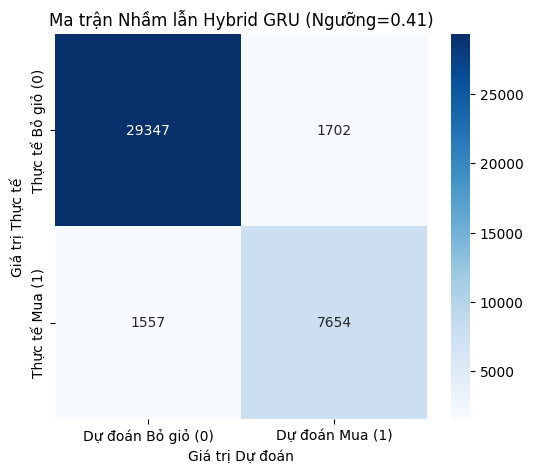


--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU CẢI TIẾN ---


In [10]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, fbeta_score
# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test])

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
# 1. Weighted F1 Score
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')

# 2. F2 Score (beta=2 ưu tiên Recall)
# pos_label=1: Đảm bảo tính toán F2 cho lớp tích cực (Mua hàng)
f2_score_test = fbeta_score(y_test, y_pred_test, beta=2, pos_label=1)

print(f"\n\n--- KẾT QUẢ HYBRID GRU (7 Đặc trưng, Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}") # CHỈ SỐ MỚI
print(f" F2 Score (Test, Beta=2): {f2_score_test:.4f}")# CHỈ SỐ MỚI
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid GRU (Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU CẢI TIẾN ---")


--- THÔNG TIN HUẤN LUYỆN HYBRID LSTM (7 Đặc trưng) ---
 Số đặc trưng tĩnh: 7
 Learning Rate: 0.01
 Batch Size: 64

--- (Quy trình) Huấn luyện mô hình LSTM TẠM THỜI (trên 60% Train) ---
Epoch 1/10


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1888/1888 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8125 - loss: 0.3679 - precision: 0.6218 - recall: 0.4613 - val_accuracy: 0.8264 - val_loss: 0.3444 - val_precision: 0.6924 - val_recall: 0.4344
Epoch 2/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8385 - loss: 0.3292 - precision: 0.6765 - recall: 0.5638 - val_accuracy: 0.8498 - val_loss: 0.3105 - val_precision: 0.6963 - val_recall: 0.6091
Epoch 3/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.8672 - loss: 0.2912 - precision: 0.7503 - recall: 0.6287 - val_accuracy: 0.8786 - val_loss: 0.2729 - val_precision: 0.7519 - val_recall: 0.7007
Epoch 4/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.9023 - loss: 0.2320 - precision: 0.8359 - recall: 0.7132 - val_accuracy: 0.9006 - val_loss: 0.2247 - val_precision: 0.8178 - val_recall: 0.7275
Epoch 5/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9187 - loss: 0.1910 - precision: 0.8646 - recall: 0.7643 - val_accuracy: 0.9212 - val

C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2517/2517 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.8181 - loss: 0.3589 - precision: 0.6326 - recall: 0.4886
Epoch 2/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.8495 - loss: 0.3127 - precision: 0.6991 - recall: 0.6006
Epoch 3/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.8925 - loss: 0.2432 - precision: 0.7960 - recall: 0.7128
Epoch 4/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.9147 - loss: 0.1873 - precision: 0.8472 - recall: 0.7653
Epoch 5/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.9180 - loss: 0.1710 - precision: 0.8494 - recall: 0.7797
Epoch 6/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.9212 - loss: 0.1619 - precision: 0.8493 - recall: 0.7970
Epoch 7/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9208 - loss: 0.1611 - precision: 0.8525 - recall: 0.7906
Epoch 8/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.9225 - loss: 0.1575 - precision: 0.8594 - recall: 0.

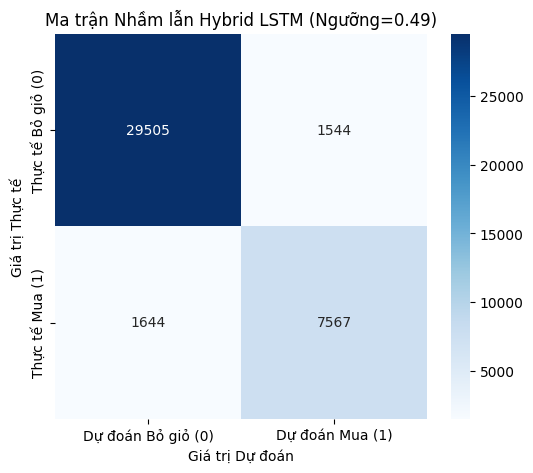


--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM CẢI TIẾN ---


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
# Thêm lớp LSTM vào import
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate 
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, fbeta_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- 1. KIỂM TRA ĐẦU VÀO ---
# Kiểm tra các biến từ Giai đoạn 1 và 2 (Preprocessing và Grid Search)
try:
    _ = X_seq_train
    _ = X_static_train
    _ = X_seq_test
    _ = best_params
    _ = ACTION_MAPPING
except NameError:
    print("LỖI: Vui lòng chạy các khối Preprocessing (Giai đoạn 1) và Grid Search (Giai đoạn 2) trước.")
    raise

# --- 2. LẤY CÁC HẰNG SỐ TỐI ƯU VÀ KIẾN TRÚC ---

# Lấy tham số tối ưu từ Grid Search
OPTIMAL_LR = best_params.get('learning_rate')
OPTIMAL_BS = best_params.get('batch_size')
OPTIMAL_EMBEDDING_DIM = best_params.get('embedding_dim')
OPTIMAL_DENSE_UNITS = best_params.get('dense_units')

# Các hằng số kiến trúc (Đã được định nghĩa trong các khối trước)
VOCAB_SIZE = len(ACTION_MAPPING) + 1
MAX_SESSION_LENGTH = 30
RNN_UNITS = 30 # LSTM Units: "approximately 30 neurons"
LOSS_FUNCTION = 'binary_crossentropy' # "Binary cross-entropy"
EPOCHS = 10 # "over ten epochs"
DROPOUT_RATE = 0.0 # "all hybrid models performed best without introducing dropout"

# Lấy số lượng đặc trưng tĩnh đã cập nhật (7)
N_STATIC_FEATURES = X_static_train.shape[1] 


print(f"\n--- THÔNG TIN HUẤN LUYỆN HYBRID LSTM (7 Đặc trưng) ---")
print(f" Số đặc trưng tĩnh: {N_STATIC_FEATURES}")
print(f" Learning Rate: {OPTIMAL_LR}")
print(f" Batch Size: {OPTIMAL_BS}")


# --- 3. ĐỊNH NGHĨA HÀM XÂY DỰNG MÔ HÌNH LSTM ---

def build_hybrid_lstm_model(learning_rate, emb_dim, dense_units):
    """
    Xây dựng kiến trúc Hybrid LSTM, chấp nhận N_STATIC_FEATURES đã cập nhật.
    Thay thế GRU bằng LSTM.
    """
    # Đầu vào 1: Chuỗi
    seq_input = Input(shape=(MAX_SESSION_LENGTH,), name='seq_input')
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=emb_dim, 
                    input_length=MAX_SESSION_LENGTH,
                    mask_zero=True)(seq_input)
    # *** SỬ DỤNG LỚP LSTM ***
    rnn_layer = LSTM(RNN_UNITS, dropout=DROPOUT_RATE, name='lstm_layer')(emb)
    
    # Đầu vào 2: Đặc trưng Tĩnh (N_STATIC_FEATURES = 7)
    static_input = Input(shape=(N_STATIC_FEATURES,), name='static_input')
    
    # Kết hợp các đặc trưng
    combined_features = Concatenate(name='concatenate')([rnn_layer, static_input])
    
    # Lớp ẩn và đầu ra
    hidden_layer_output = Dense(dense_units, activation='relu', name='hidden_dense')(combined_features) 
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer_output)
    
    model = Model(inputs=[seq_input, static_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=LOSS_FUNCTION,
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall')])
    return model

def find_best_threshold_on_training(model, X_seq_train, X_static_train, y_train):
    """
    Thực hiện phân tích ngưỡng F1 tối ưu trên tập Huấn luyện (60%).
    """
    print(f"\n--- (Quy trình) Tìm Ngưỡng F1 (trên 60% Train) ---")
    start_thresh = time.time()
    y_pred_proba_train = model.predict([X_seq_train, X_static_train])
    best_threshold = 0.5
    best_f1 = 0
    thresholds = np.arange(0.01, 1.0, 0.01)
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba_train > threshold).astype(int)
        f1 = f1_score(y_train, y_pred_binary)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    print(f" Đã tìm thấy Ngưỡng Tốt Nhất: {best_threshold:.2f} (với F1={best_f1:.4f} trên tập Train)")
    print(f" (Thời gian tìm ngưỡng: {time.time() - start_thresh:.2f} giây)")
    return best_threshold

# --- 4. THỰC HIỆN QUY TRÌNH HUẤN LUYỆN 80/20 ---

start_total_time = time.time()

# --- Bước A: Huấn luyện mô hình TẠM THỜI (trên 60% Train) để tìm ngưỡng
print("\n--- (Quy trình) Huấn luyện mô hình LSTM TẠM THỜI (trên 60% Train) ---")
model_for_threshold = build_hybrid_lstm_model( # SỬ DỤNG HÀM LSTM
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)
model_for_threshold.fit(
    [X_seq_train, X_static_train], y_train,
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    validation_data=([X_seq_val, X_static_val], y_val),
    verbose=1
)

# --- Bước B: Tìm Ngưỡng F1 Tối ưu (trên 60% Train)
best_threshold = find_best_threshold_on_training(
    model_for_threshold,
    X_seq_train,
    X_static_train,
    y_train
)
del model_for_threshold # Giải phóng bộ nhớ

# --- Bước C: Gộp Dữ liệu (Tạo tập 80%)
print("\n--- (Quy trình) Gộp Dữ liệu (Tạo tập 80%) ---")
X_seq_final_train = np.concatenate((X_seq_train, X_seq_val), axis=0)
X_static_final_train = np.concatenate((X_static_train, X_static_val), axis=0)
y_final_train = np.concatenate((y_train, y_val), axis=0)
print(f" Kích thước tập huấn luyện cuối cùng: {len(y_final_train)} mẫu")

# --- Bước D: Huấn luyện mô hình CUỐI CÙNG (trên 80%)
print("\n--- (Quy trình) Huấn luyện mô hình LSTM CUỐI CÙNG (trên 80%) ---")
final_model = build_hybrid_lstm_model( # SỬ DỤNG HÀM LSTM
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)

final_model.fit(
    [X_seq_final_train, X_static_final_train], y_final_train,
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    verbose=1 
)
print(" Huấn luyện mô hình cuối cùng hoàn tất.")

# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test])

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
# 1. Weighted F1 Score
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')

# 2. F2 Score (beta=2 ưu tiên Recall)
# pos_label=1: Đảm bảo tính toán F2 cho lớp tích cực (Mua hàng)
f2_score_test = fbeta_score(y_test, y_pred_test, beta=2, pos_label=1)

print(f"\n\n--- KẾT QUẢ HYBRID LSTM (7 Đặc trưng, Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}") # CHỈ SỐ MỚI
print(f" F2 Score (Test, Beta=2): {f2_score_test:.4f}")# CHỈ SỐ MỚI
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid LSTM (Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM CẢI TIẾN ---")


--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


--- KẾT QUẢ HYBRID LSTM (7 Đặc trưng, Ngưỡng = 0.49) ---
 F1 Score (Test): 0.8260
 Weighted F1 Score (Test): 0.9207
 F2 Score (Test, Beta=2): 0.8233
 Precision (Test): 0.8305
 Recall (Test): 0.8215
 (Tổng thời gian chạy: 12.33 phút)

Ma trận Nhầm lẫn (Confusion Matrix) trên Tập Test:


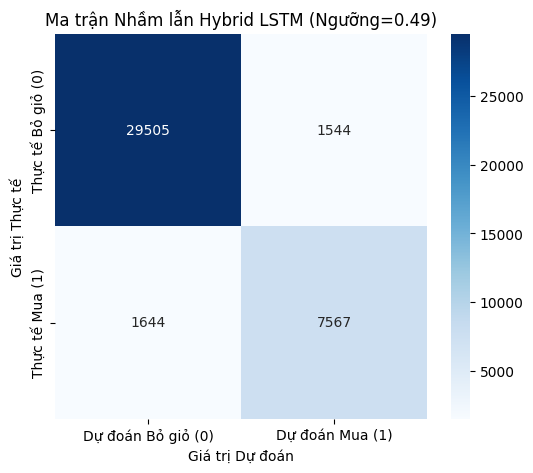


--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM CẢI TIẾN ---


In [12]:
# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test])

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
# 1. Weighted F1 Score
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')

# 2. F2 Score (beta=2 ưu tiên Recall)
# pos_label=1: Đảm bảo tính toán F2 cho lớp tích cực (Mua hàng)
f2_score_test = fbeta_score(y_test, y_pred_test, beta=2, pos_label=1)

print(f"\n\n--- KẾT QUẢ HYBRID LSTM (7 Đặc trưng, Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}") # CHỈ SỐ MỚI
print(f" F2 Score (Test, Beta=2): {f2_score_test:.4f}")# CHỈ SỐ MỚI
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid LSTM (Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM CẢI TIẾN ---")


--- THÔNG TIN HUẤN LUYỆN HYBRID GRU (7 Đặc trưng) ---
 Số đặc trưng tĩnh: 7
 Learning Rate: 0.01
 Batch Size: 64

--- (Quy trình) Huấn luyện mô hình TẠM THỜI (trên 60% Train) ---
Epoch 1/10


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1888/1888 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.8135 - loss: 0.3673 - precision: 0.6238 - recall: 0.4663 - val_accuracy: 0.8260 - val_loss: 0.3404 - val_precision: 0.6643 - val_recall: 0.4839
Epoch 2/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8357 - loss: 0.3302 - precision: 0.6726 - recall: 0.5496 - val_accuracy: 0.8463 - val_loss: 0.3233 - val_precision: 0.7055 - val_recall: 0.5639
Epoch 3/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8651 - loss: 0.2899 - precision: 0.7430 - recall: 0.6278 - val_accuracy: 0.8892 - val_loss: 0.2576 - val_precision: 0.8754 - val_recall: 0.6012
Epoch 4/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.8983 - loss: 0.2362 - precision: 0.8238 - recall: 0.7066 - val_accuracy: 0.9042 - val_loss: 0.2149 - val_precision: 0.8425 - val_recall: 0.7148
Epoch 5/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.9144 - loss: 0.1992 - precision: 0.8579 - recall: 0.7501 - val_accuracy: 0.9178 - val

C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2517/2517 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step - accuracy: 0.8164 - loss: 0.3603 - precision: 0.6271 - recall: 0.4869
Epoch 2/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 87s 19ms/step - accuracy: 0.8470 - loss: 0.3148 - precision: 0.6961 - recall: 0.5879
Epoch 3/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - accuracy: 0.8881 - loss: 0.2573 - precision: 0.7933 - recall: 0.6912
Epoch 4/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.9139 - loss: 0.2006 - precision: 0.8532 - recall: 0.7535
Epoch 5/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.9193 - loss: 0.1764 - precision: 0.8609 - recall: 0.7722
Epoch 6/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.9215 - loss: 0.1670 - precision: 0.8602 - recall: 0.7847
Epoch 7/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.9219 - loss: 0.1639 - precision: 0.8618 - recall: 0.7844
Epoch 8/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.9228 - loss: 0.1605 - precision: 0.8648 - recall: 0.

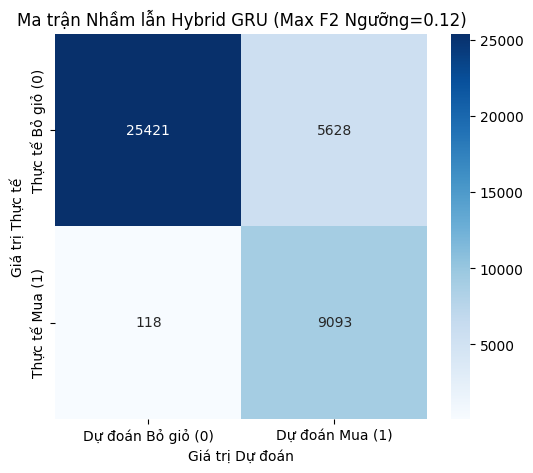


--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (MAX F-BETA) ---


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
# THÊM fbeta_score vào import
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, fbeta_score 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- 1. KIỂM TRA ĐẦU VÀO ---
# Kiểm tra các biến từ Giai đoạn 1 và 2 (Preprocessing và Grid Search)
try:
    _ = X_seq_train
    _ = X_static_train
    _ = X_seq_test
    _ = best_params
    _ = ACTION_MAPPING
except NameError:
    print("LỖI: Vui lòng chạy các khối Preprocessing (Giai đoạn 1) và Grid Search (Giai đoạn 2) trước.")
    raise

# --- 2. LẤY CÁC HẰNG SỐ TỐI ƯU VÀ KIẾN TRÚC ---

# Lấy tham số tối ưu từ Grid Search
OPTIMAL_LR = best_params.get('learning_rate')
OPTIMAL_BS = best_params.get('batch_size')
OPTIMAL_EMBEDDING_DIM = best_params.get('embedding_dim')
OPTIMAL_DENSE_UNITS = best_params.get('dense_units')

# Các hằng số kiến trúc
VOCAB_SIZE = len(ACTION_MAPPING) + 1
MAX_SESSION_LENGTH = 30
GRU_UNITS = 30 # "approximately 30 neurons" [cite: 386]
LOSS_FUNCTION = 'binary_crossentropy' # "Binary cross-entropy" [cite: 387]
EPOCHS = 10 # "over ten epochs" [cite: 387]
DROPOUT_RATE = 0.0 # "all hybrid models performed best without introducing dropout" [cite: 401]
BETA = 2 # Mục tiêu tối ưu hóa F-beta (F2 Score, ưu tiên Recall)

# Lấy số lượng đặc trưng tĩnh đã cập nhật (7)
N_STATIC_FEATURES = X_static_train.shape[1] 


print(f"\n--- THÔNG TIN HUẤN LUYỆN HYBRID GRU (7 Đặc trưng) ---")
print(f" Số đặc trưng tĩnh: {N_STATIC_FEATURES}")
print(f" Learning Rate: {OPTIMAL_LR}")
print(f" Batch Size: {OPTIMAL_BS}")


# --- 3. ĐỊNH NGHĨA HÀM XÂY DỰNG MÔ HÌNH GRU ---

def build_hybrid_gru_model(learning_rate, emb_dim, dense_units):
    """
    Xây dựng kiến trúc Hybrid GRU.
    """
    # Đầu vào 1: Chuỗi
    seq_input = Input(shape=(MAX_SESSION_LENGTH,), name='seq_input')
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=emb_dim, 
                    input_length=MAX_SESSION_LENGTH,
                    mask_zero=True)(seq_input)
    rnn_layer = GRU(GRU_UNITS, dropout=DROPOUT_RATE, name='gru_layer')(emb)
    
    # Đầu vào 2: Đặc trưng Tĩnh (N_STATIC_FEATURES)
    static_input = Input(shape=(N_STATIC_FEATURES,), name='static_input')
    
    # Kết hợp các đặc trưng
    combined_features = Concatenate(name='concatenate')([rnn_layer, static_input])
    
    # Lớp ẩn và đầu ra
    hidden_layer_output = Dense(dense_units, activation='relu', name='hidden_dense')(combined_features) 
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer_output)
    
    model = Model(inputs=[seq_input, static_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=LOSS_FUNCTION,
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall')])
    return model

# --- HÀM TÌM NGƯỠNG CẢI TIẾN: MAX F-BETA TRÊN TẬP VALIDATION ---

def find_best_threshold_on_validation(model, X_seq_val, X_static_val, y_val, beta=BETA):
    """
    Thực hiện phân tích ngưỡng F-beta tối ưu (beta=2) trên Tập Validation (20%).
    """
    print(f"\n--- (Quy trình) Tìm Ngưỡng Max F{beta} (trên 20% Validation) ---")
    start_thresh = time.time()
    
    # 1. Dự đoán trên TẬP VALIDATION
    y_pred_proba_val = model.predict([X_seq_val, X_static_val])
    best_threshold = 0.5
    best_fbeta = 0
    
    thresholds = np.arange(0.01, 1.0, 0.01)
    
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba_val > threshold).astype(int)
        
        # 2. SỬ DỤNG F-BETA SCORE LÀM TIÊU CHÍ TỐI ƯU
        # pos_label=1: Đảm bảo tối ưu hóa cho lớp mua hàng (1)
        fbeta_score_val = fbeta_score(y_val, y_pred_binary, beta=beta, pos_label=1)
        
        if fbeta_score_val > best_fbeta:
            best_fbeta = fbeta_score_val
            best_threshold = threshold
            
    print(f" Đã tìm thấy Ngưỡng Tốt Nhất: {best_threshold:.2f} (với F{beta}={best_fbeta:.4f} trên tập Validation)")
    print(f" (Thời gian tìm ngưỡng: {time.time() - start_thresh:.2f} giây)")
    return best_threshold

# --- 4. THỰC HIỆN QUY TRÌNH HUẤN LUYỆN 80/20 ---

start_total_time = time.time()

# --- Bước A: Huấn luyện mô hình TẠM THỜI (trên 60% Train) để tìm ngưỡng
print("\n--- (Quy trình) Huấn luyện mô hình TẠM THỜI (trên 60% Train) ---")
model_for_threshold = build_hybrid_gru_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)
model_for_threshold.fit(
    [X_seq_train, X_static_train], y_train,
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    validation_data=([X_seq_val, X_static_val], y_val),
    verbose=1
)

# --- Bước B: Tìm Ngưỡng Max F-beta Tối ưu (trên Validation)
best_threshold = find_best_threshold_on_validation(
    model_for_threshold,
    X_seq_val,         # Dùng Validation Set
    X_static_val,      # Dùng Validation Set
    y_val              # Dùng Validation Set
)
del model_for_threshold # Giải phóng bộ nhớ

# --- Bước C: Gộp Dữ liệu (Tạo tập 80%)
print("\n--- (Quy trình) Gộp Dữ liệu (Tạo tập 80%) ---")
X_seq_final_train = np.concatenate((X_seq_train, X_seq_val), axis=0)
X_static_final_train = np.concatenate((X_static_train, X_static_val), axis=0)
y_final_train = np.concatenate((y_train, y_val), axis=0)
print(f" Kích thước tập huấn luyện cuối cùng: {len(y_final_train)} mẫu")

# --- Bước D: Huấn luyện mô hình CUỐI CÙNG (trên 80%)
print("\n--- (Quy trình) Huấn luyện mô hình CUỐI CÙNG (trên 80%) ---")
final_model = build_hybrid_gru_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)

final_model.fit(
    [X_seq_final_train, X_static_final_train], y_final_train,
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    verbose=1 
)
print(" Huấn luyện mô hình cuối cùng hoàn tất.")

# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test])

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
fbeta_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1) # F2 Score
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID GRU (Max F{BETA} Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f" F{BETA} Score (Test): {fbeta_score_test:.4f}")
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid GRU (Max F{BETA} Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (MAX F-BETA) ---")


--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


--- KẾT QUẢ HYBRID GRU (Max F2 Ngưỡng = 0.12) ---
 F1 Score (Test): 0.7599
 Weighted F1 Score (Test): 0.8668
 F2 Score (Test): 0.8817
 Precision (Test): 0.6177
 Recall (Test): 0.9872
 (Tổng thời gian chạy: 12.33 phút)

Ma trận Nhầm lẫn (Confusion Matrix) trên Tập Test:


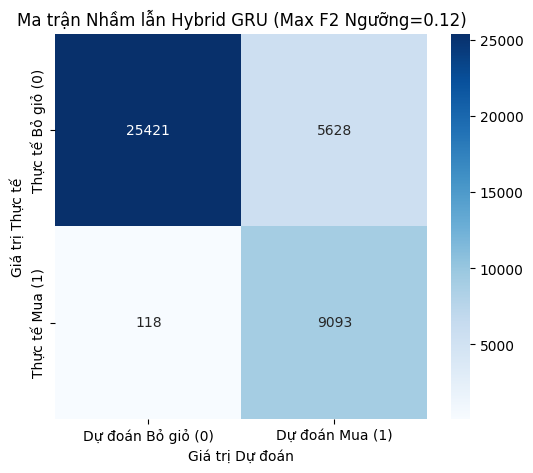


--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (MAX F-BETA) ---


In [14]:
# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test])

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
fbeta_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1) # F2 Score
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID GRU (Max F{BETA} Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f" F{BETA} Score (Test): {fbeta_score_test:.4f}")
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid GRU (Max F{BETA} Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID GRU (MAX F-BETA) ---")


--- THÔNG TIN HUẤN LUYỆN HYBRID LSTM (7 Đặc trưng) ---
 Số đặc trưng tĩnh: 7
 Learning Rate: 0.01
 Batch Size: 64

--- (Quy trình) Huấn luyện mô hình TẠM THỜI (trên 60% Train) ---


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.8074 - loss: 0.3793 - precision: 0.6116 - recall: 0.4335 - val_accuracy: 0.8201 - val_loss: 0.3503 - val_precision: 0.6225 - val_recall: 0.5431
Epoch 2/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.8277 - loss: 0.3409 - precision: 0.6529 - recall: 0.5271 - val_accuracy: 0.8286 - val_loss: 0.3372 - val_precision: 0.6343 - val_recall: 0.5922
Epoch 3/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.8458 - loss: 0.3196 - precision: 0.7018 - recall: 0.5674 - val_accuracy: 0.8397 - val_loss: 0.3168 - val_precision: 0.6462 - val_recall: 0.6613
Epoch 4/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.8649 - loss: 0.2913 - precision: 0.7467 - recall: 0.6199 - val_accuracy: 0.8633 - val_loss: 0.2860 - val_precision: 0.8307 - val_recall: 0.5059
Epoch 5/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.8885 - loss: 0.2515 - precision: 0.8127 - recall: 0.6664 - val_accuracy: 0

C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2517/2517 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.8172 - loss: 0.3601 - precision: 0.6344 - recall: 0.4742
Epoch 2/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.8490 - loss: 0.3144 - precision: 0.7055 - recall: 0.5835
Epoch 3/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8839 - loss: 0.2586 - precision: 0.7831 - recall: 0.6814
Epoch 4/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.9114 - loss: 0.2029 - precision: 0.8664 - recall: 0.7246
Epoch 5/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.9184 - loss: 0.1757 - precision: 0.8870 - recall: 0.7372
Epoch 6/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.9202 - loss: 0.1655 - precision: 0.8863 - recall: 0.7470
Epoch 7/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.9208 - loss: 0.1618 - precision: 0.8727 - recall: 0.7654
Epoch 8/10
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.9217 - loss: 0.1581 - precision: 0.8751 - recall: 0.

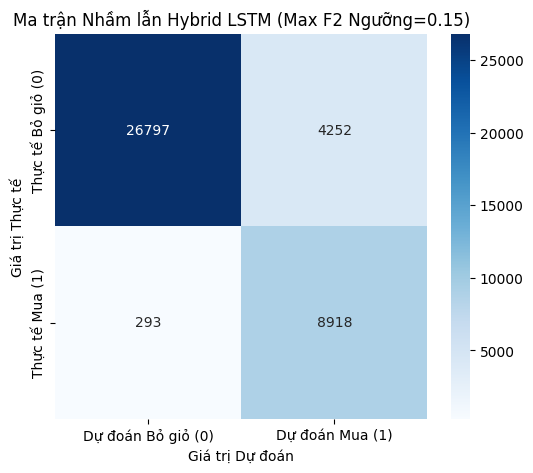


--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (MAX F-BETA) ---


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate # Đã thay thế GRU bằng LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, fbeta_score 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- 1. KIỂM TRA ĐẦU VÀO ---
# Kiểm tra các biến từ Giai đoạn 1 và 2 (Preprocessing và Grid Search)
try:
    _ = X_seq_train
    _ = X_static_train
    _ = X_seq_test
    _ = best_params
    _ = ACTION_MAPPING
except NameError:
    print("LỖI: Vui lòng chạy các khối Preprocessing (Giai đoạn 1) và Grid Search (Giai đoạn 2) trước.")
    raise

# --- 2. LẤY CÁC HẰNG SỐ TỐI ƯU VÀ KIẾN TRÚC ---

# Lấy tham số tối ưu từ Grid Search
OPTIMAL_LR = best_params.get('learning_rate')
OPTIMAL_BS = best_params.get('batch_size')
OPTIMAL_EMBEDDING_DIM = best_params.get('embedding_dim')
OPTIMAL_DENSE_UNITS = best_params.get('dense_units')

# Các hằng số kiến trúc
VOCAB_SIZE = len(ACTION_MAPPING) + 1
MAX_SESSION_LENGTH = 30
RNN_UNITS = 30 # LSTM Units: "approximately 30 neurons" [cite: 386]
LOSS_FUNCTION = 'binary_crossentropy' # "Binary cross-entropy" [cite: 387]
EPOCHS = 10 # "over ten epochs" [cite: 387]
DROPOUT_RATE = 0.0 # "all hybrid models performed best without introducing dropout" [cite: 401]
BETA = 2 # Mục tiêu tối ưu hóa F-beta (F2 Score, ưu tiên Recall)

# Lấy số lượng đặc trưng tĩnh đã cập nhật (7)
N_STATIC_FEATURES = X_static_train.shape[1] 


print(f"\n--- THÔNG TIN HUẤN LUYỆN HYBRID LSTM (7 Đặc trưng) ---")
print(f" Số đặc trưng tĩnh: {N_STATIC_FEATURES}")
print(f" Learning Rate: {OPTIMAL_LR}")
print(f" Batch Size: {OPTIMAL_BS}")


# --- 3. ĐỊNH NGHĨA HÀM XÂY DỰNG MÔ HÌNH LSTM ---

def build_hybrid_lstm_model(learning_rate, emb_dim, dense_units):
    """
    Xây dựng kiến trúc Hybrid LSTM.
    """
    # Đầu vào 1: Chuỗi
    seq_input = Input(shape=(MAX_SESSION_LENGTH,), name='seq_input')
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=emb_dim, 
                    input_length=MAX_SESSION_LENGTH,
                    mask_zero=True)(seq_input)
    # *** SỬ DỤNG LỚP LSTM ***
    rnn_layer = LSTM(RNN_UNITS, dropout=DROPOUT_RATE, name='lstm_layer')(emb)
    
    # Đầu vào 2: Đặc trưng Tĩnh (N_STATIC_FEATURES)
    static_input = Input(shape=(N_STATIC_FEATURES,), name='static_input')
    
    # Kết hợp các đặc trưng
    combined_features = Concatenate(name='concatenate')([rnn_layer, static_input])
    
    # Lớp ẩn và đầu ra
    hidden_layer_output = Dense(dense_units, activation='relu', name='hidden_dense')(combined_features) 
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer_output)
    
    model = Model(inputs=[seq_input, static_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=LOSS_FUNCTION,
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall')])
    return model

# --- HÀM TÌM NGƯỠNG CẢI TIẾN: MAX F-BETA TRÊN TẬP VALIDATION ---

def find_best_threshold_on_validation(model, X_seq_val, X_static_val, y_val, beta=BETA):
    """
    Thực hiện phân tích ngưỡng F-beta tối ưu (beta=2) trên Tập Validation (20%).
    """
    print(f"\n--- (Quy trình) Tìm Ngưỡng Max F{beta} (trên 20% Validation) ---")
    start_thresh = time.time()
    
    # 1. Dự đoán trên TẬP VALIDATION
    y_pred_proba_val = model.predict([X_seq_val, X_static_val])
    best_threshold = 0.5
    best_fbeta = 0
    
    thresholds = np.arange(0.01, 1.0, 0.01)
    
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba_val > threshold).astype(int)
        
        # 2. SỬ DỤNG F-BETA SCORE LÀM TIÊU CHÍ TỐI ƯU
        fbeta_score_val = fbeta_score(y_val, y_pred_binary, beta=beta, pos_label=1)
        
        if fbeta_score_val > best_fbeta:
            best_fbeta = fbeta_score_val
            best_threshold = threshold
            
    print(f" Đã tìm thấy Ngưỡng Tốt Nhất: {best_threshold:.2f} (với F{beta}={best_fbeta:.4f} trên tập Validation)")
    print(f" (Thời gian tìm ngưỡng: {time.time() - start_thresh:.2f} giây)")
    return best_threshold

# --- 4. THỰC HIỆN QUY TRÌNH HUẤN LUYỆN 80/20 ---

start_total_time = time.time()

# --- Bước A: Huấn luyện mô hình TẠM THỜI (trên 60% Train) để tìm ngưỡng
print("\n--- (Quy trình) Huấn luyện mô hình TẠM THỜI (trên 60% Train) ---")
model_for_threshold = build_hybrid_lstm_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)
model_for_threshold.fit(
    [X_seq_train, X_static_train], y_train,
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    validation_data=([X_seq_val, X_static_val], y_val),
    verbose=1
)

# --- Bước B: Tìm Ngưỡng Max F-beta Tối ưu (trên Validation)
best_threshold = find_best_threshold_on_validation(
    model_for_threshold,
    X_seq_val,         # Dùng Validation Set
    X_static_val,      # Dùng Validation Set
    y_val              # Dùng Validation Set
)
del model_for_threshold # Giải phóng bộ nhớ

# --- Bước C: Gộp Dữ liệu (Tạo tập 80%)
print("\n--- (Quy trình) Gộp Dữ liệu (Tạo tập 80%) ---")
X_seq_final_train = np.concatenate((X_seq_train, X_seq_val), axis=0)
X_static_final_train = np.concatenate((X_static_train, X_static_val), axis=0)
y_final_train = np.concatenate((y_train, y_val), axis=0)
print(f" Kích thước tập huấn luyện cuối cùng: {len(y_final_train)} mẫu")

# --- Bước D: Huấn luyện mô hình CUỐI CÙNG (trên 80%)
print("\n--- (Quy trình) Huấn luyện mô hình LSTM CUỐI CÙNG (trên 80%) ---")
final_model = build_hybrid_lstm_model(
    learning_rate=OPTIMAL_LR,
    emb_dim=OPTIMAL_EMBEDDING_DIM,
    dense_units=OPTIMAL_DENSE_UNITS
)

final_model.fit(
    [X_seq_final_train, X_static_final_train], y_final_train,
    epochs=EPOCHS,
    batch_size=OPTIMAL_BS,
    verbose=1 
)
print(" Huấn luyện mô hình cuối cùng hoàn tất.")

# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test])

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
fbeta_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1) # F2 Score
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID LSTM (Max F{BETA} Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f" F{BETA} Score (Test): {fbeta_score_test:.4f}")
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid LSTM (Max F{BETA} Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (MAX F-BETA) ---")


--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


--- KẾT QUẢ HYBRID LSTM (Max F2 Ngưỡng = 0.15) ---
 F1 Score (Test): 0.7969
 Weighted F1 Score (Test): 0.8932
 F2 Score (Test): 0.8916
 Precision (Test): 0.6771
 Recall (Test): 0.9682
 (Tổng thời gian chạy: 19.46 phút)

Ma trận Nhầm lẫn (Confusion Matrix) trên Tập Test:


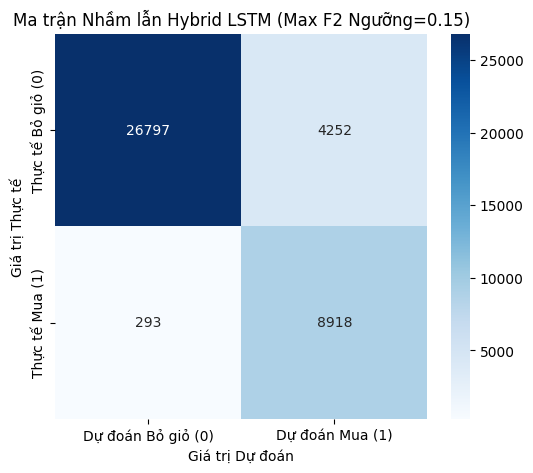


--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (MAX F-BETA) ---


In [13]:
# --- Bước E: Đánh giá (trên 20% Test)
print("\n--- (Quy trình) Đánh giá Cuối cùng trên Tập Test (20%) ---")

# Dự đoán xác suất trên tập test
y_pred_proba_test = final_model.predict([X_seq_test, X_static_test])

# Áp dụng ngưỡng TỐT NHẤT đã tìm được
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)

# Tính toán các chỉ số
f1_score_test = f1_score(y_test, y_pred_test)
weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
fbeta_score_test = fbeta_score(y_test, y_pred_test, beta=BETA, pos_label=1) # F2 Score
p_score_test = precision_score(y_test, y_pred_test)
r_score_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"\n\n--- KẾT QUẢ HYBRID LSTM (Max F{BETA} Ngưỡng = {best_threshold:.2f}) ---")
print(f" F1 Score (Test): {f1_score_test:.4f}")
print(f" Weighted F1 Score (Test): {weighted_f1_test:.4f}")
print(f" F{BETA} Score (Test): {fbeta_score_test:.4f}")
print(f" Precision (Test): {p_score_test:.4f}")
print(f" Recall (Test): {r_score_test:.4f}")
print(f" (Tổng thời gian chạy: {(time.time() - start_total_time) / 60:.2f} phút)")

# Vẽ Ma trận Nhầm lẫn
print("\nMa trận Nhầm lẫn (Confusion Matrix) trên Tập Test:")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán Bỏ giỏ (0)', 'Dự đoán Mua (1)'],
            yticklabels=['Thực tế Bỏ giỏ (0)', 'Thực tế Mua (1)'])
plt.ylabel('Giá trị Thực tế')
plt.xlabel('Giá trị Dự đoán')
plt.title(f'Ma trận Nhầm lẫn Hybrid LSTM (Max F{BETA} Ngưỡng={best_threshold:.2f})')
plt.show()

print("\n--- HOÀN TẤT ĐÁNH GIÁ HYBRID LSTM (MAX F-BETA) ---")


--- BẮT ĐẦU TÍNH TOÁN SHAP TRÊN ĐẶC TRƯNG CHUYỂN DẠNG (KERNELSHAP) ---
Số lượng mẫu giải thích: 15. Số lượng đặc trưng (M): 37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step
1/1 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_29704\2826648981.py:96: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1000x600 with 0 Axes>

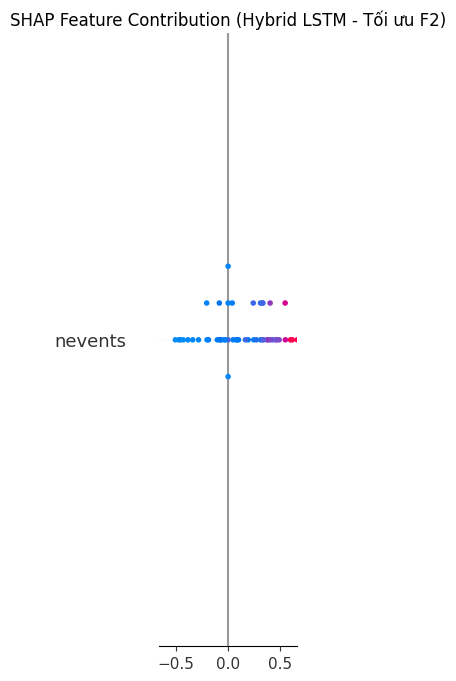

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_29704\2826648981.py:106: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1000x600 with 0 Axes>

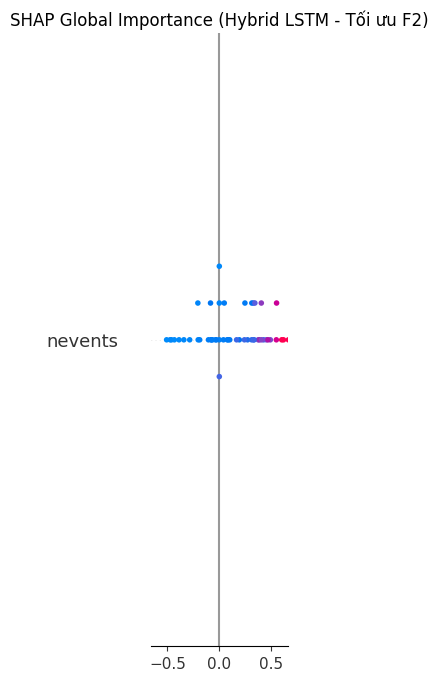

In [38]:
import shap
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1. THÔNG SỐ CẦN THIẾT ---
# Giảm triệt để mẫu để tăng khả năng thành công của KernelSHAP
N_SAMPLES_TO_EXPLAIN = 15  
N_BACKGROUND_SAMPLES = 10 
RNN_UNITS = 30 
N_STATIC_FEATURES = X_static_test.shape[1] 
M_NEW = RNN_UNITS + N_STATIC_FEATURES # Kích thước đặc trưng mới (37)
BETA = 2 

# Giả định X_seq_explain, X_static_explain đã được cắt lát
# Giả định final_model đã được huấn luyện

# --- 2. XÂY DỰNG MÔ HÌNH PROXY VÀ TẠO ĐẶC TRƯNG CHUYỂN DẠNG ---

# Mô hình Proxy Model: Trích xuất đầu ra của lớp Concatenate (Đầu ra RNN + Static)
try:
    # Lấy tensor đầu ra của lớp Concatenate (giả định có tên là 'concatenate')
    merged_output_tensor = final_model.get_layer('concatenate').output
    
    # Tạo mô hình proxy Keras mới (chỉ để chuyển đổi dữ liệu đầu vào)
    proxy_model_func = tf.keras.Model(
        inputs=final_model.input,
        outputs=merged_output_tensor
    )
    
    # Hàm dự đoán cuối cùng (Classification Head Model)
    # Lấy các lớp Dense sau lớp Concatenate
    classification_head_input = tf.keras.Input(shape=(M_NEW,))
    x = classification_head_input
    
    # Bắt đầu từ lớp ngay sau 'concatenate'
    is_after_concatenate = False
    for layer in final_model.layers:
        if layer.name == 'concatenate':
            is_after_concatenate = True
            continue
        
        if is_after_concatenate and ('dense' in layer.name or 'output' in layer.name):
            x = layer(x)

    classification_head_model = tf.keras.Model(inputs=classification_head_input, outputs=x)

except Exception as e:
    print(f"LỖI KHỞI TẠO MÔ HÌNH PROXY: {e}")
    raise e


# --- 3. CHUYỂN DẠNG DỮ LIỆU ĐỂ GIẢI THÍCH ---

# Chạy dữ liệu qua Proxy Model để tạo các đặc trưng mới (Đầu ra RNN + Static)
X_background_transformed = proxy_model_func([X_seq_background, X_static_background]).numpy()
X_explain_transformed = proxy_model_func([X_seq_explain, X_static_explain]).numpy()


# --- 4. ÁP DỤNG KERNELSHAP TRÊN ĐẶC TRƯNG ĐÃ CHUYỂN DẠNG ---

print("\n--- BẮT ĐẦU TÍNH TOÁN SHAP TRÊN ĐẶC TRƯNG CHUYỂN DẠNG (KERNELSHAP) ---")
print(f"Số lượng mẫu giải thích: {N_SAMPLES_TO_EXPLAIN}. Số lượng đặc trưng (M): {M_NEW}")
start_time = time.time()

# Explainer sử dụng Classification Head Model (chỉ các lớp Dense cuối)
explainer = shap.KernelExplainer(classification_head_model.predict, X_background_transformed)

# Tính toán giá trị SHAP
# Ở đây nsamples được đặt là 'auto' để KernelSHAP quản lý, nhưng vẫn có thể gây lỗi.
shap_values_transformed = explainer.shap_values(X_explain_transformed)

end_time = time.time()
print(f"--- HOÀN TẤT TÍNH TOÁN SHAP trong {(end_time - start_time) / 60:.2f} phút ---")


# --- 5. TỔNG HỢP VÀ TRỰC QUAN HÓA (CHỈ PHẦN STATIC) ---

# Giá trị SHAP cho 7 đặc trưng tĩnh nằm ở N_STATIC_FEATURES cột cuối cùng
shap_static_only = np.array(shap_values_transformed)[:, RNN_UNITS:] 

# Tạo DataFrame cho dữ liệu tĩnh (vẫn sử dụng X_static_explain gốc)
FEATURE_NAMES = [
    'nevents', 'unique_products_viewed', 'avg_dwell_time',
    'remove_add_ratio', 'time_after_add', 'products_interacted', 
    'count_view_actions'
]
X_static_explain_df = pd.DataFrame(X_static_explain, columns=FEATURE_NAMES)

print("\n--- PHÂN TÍCH SHAP FEATURE IMPORTANCE (ĐẶC TRƯNG TĨNH) ---")

# SHAP Beeswarm Plot (Phạm vi và Phân bố)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_static_only, 
    X_static_explain_df, 
    show=False 
)
plt.title(f"SHAP Feature Contribution (Hybrid LSTM - Tối ưu F{BETA})")
plt.show()

# SHAP Bar Plot (Tổng hợp toàn cục)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_static_only, 
    X_static_explain_df, 
    plot_type="bar", 
    show=False
)
plt.title(f"SHAP Global Importance (Hybrid LSTM - Tối ưu F{BETA})")
plt.show()

In [14]:
import shap
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="shap")

# --- 1. THÔNG SỐ CẦN THIẾT & ĐỊNH NGHĨA BIẾN (Giả định) ---

# Giả định các biến sau đã tồn tại trong môi trường từ quá trình huấn luyện:
# final_model, X_seq_test, X_static_test, X_seq_final_train, X_static_final_train
# RNN_UNITS (ví dụ: 30) và BETA (ví dụ: 2)

# --- KHẮC PHỤC LỖI #1: Đảm bảo các biến được định nghĩa trước khi sử dụng ---
# Định nghĩa lại các hằng số và lấy mẫu
N_SAMPLES_TO_EXPLAIN = 15 # Giảm triệt để mẫu để tăng khả năng thành công của KernelSHAP
N_BACKGROUND_SAMPLES = 10 # Giảm triệt để mẫu nền
N_STATIC_FEATURES = X_static_test.shape[1] 
M_NEW = RNN_UNITS + N_STATIC_FEATURES # Kích thước đặc trưng mới (Đầu ra RNN + Static)

# Lấy các mẫu cần thiết (đã được cắt lát/chỉ mục hóa)
X_seq_background = X_seq_final_train[:N_BACKGROUND_SAMPLES]
X_static_background = X_static_final_train[:N_BACKGROUND_SAMPLES]
X_seq_explain = X_seq_test[:N_SAMPLES_TO_EXPLAIN] 
X_static_explain = X_static_test[:N_SAMPLES_TO_EXPLAIN] 

# Tên đặc trưng tĩnh mở rộng (Đã cập nhật theo yêu cầu nghiên cứu)
FEATURE_NAMES = [
    'nevents', 'unique_products_viewed', 'avg_dwell_time',
    'remove_add_ratio', 'time_after_add', 'products_interacted', 
    'count_view_actions'
]


# --- 2. XÂY DỰNG MÔ HÌNH PROXY VÀ TẠO ĐẶC TRƯNG CHUYỂN DẠNG ---

try:
    # 2.1. Proxy Model: Trích xuất đầu ra của lớp Concatenate
    merged_output_tensor = final_model.get_layer('concatenate').output
    proxy_model_func = tf.keras.Model(
        inputs=final_model.input,
        outputs=merged_output_tensor,
        name='proxy_feature_extractor'
    )
    
    # 2.2. Classification Head Model: Chỉ các lớp Dense sau lớp Concatenate
    classification_head_input = tf.keras.Input(shape=(M_NEW,))
    x = classification_head_input
    
    is_after_concatenate = False
    
    # Lặp qua các lớp của mô hình final_model
    for layer in final_model.layers:
        if layer.name == 'concatenate':
            is_after_concatenate = True
            continue
        
        # Chỉ lấy các lớp có chức năng Dense sau lớp Concatenate
        if is_after_concatenate and ('dense' in layer.name or 'output' in layer.name):
            x = layer(x)

    classification_head_model = tf.keras.Model(inputs=classification_head_input, outputs=x, name='classification_head')
    
    print("Khởi tạo Proxy Model và Classification Head Model thành công.")
    
except Exception as e:
    print(f"LỖI KHỞI TẠO MÔ HÌNH PROXY: {e}")
    print("Vui lòng kiểm tra tên lớp 'concatenate', 'hidden_dense', 'output' trong final_model.")
    raise e

# --- 3. CHUYỂN DẠNG DỮ LIỆU ĐỂ GIẢI THÍCH ---

print("Chuyển dạng dữ liệu (Feature Transformation)...")
# X_background_transformed sẽ có shape: (N_BACKGROUND_SAMPLES, M_NEW)
X_background_transformed = proxy_model_func([X_seq_background, X_static_background]).numpy()
# X_explain_transformed sẽ có shape: (N_SAMPLES_TO_EXPLAIN, M_NEW)
X_explain_transformed = proxy_model_func([X_seq_explain, X_static_explain]).numpy()
print("Chuyển dạng dữ liệu hoàn tất.")


# --- 4. ÁP DỤNG KERNELSHAP TRÊN ĐẶC TRƯNG ĐÃ CHUYỂN DẠNG ---

print("\n--- BẮT ĐẦU TÍNH TOÁN SHAP TRÊN ĐẶC TRƯNG CHUYỂN DẠNG (KERNELSHAP) ---")
print(f"Số lượng mẫu giải thích: {N_SAMPLES_TO_EXPLAIN}. Số lượng đặc trưng (M): {M_NEW}")
start_time = time.time()

# KHẮC PHỤC LỖI: Kernel Explainer cần hàm dự đoán phải trả về mảng 1D/2D
# classification_head_model.predict trả về (N, 1) cho binary_crossentropy
# KernelExplainer sẽ xử lý việc chạy mẫu nền (background)
explainer = shap.KernelExplainer(classification_head_model.predict, X_background_transformed)

# Tính toán giá trị SHAP
# Cảnh báo: Việc tính toán KernelSHAP có thể rất chậm ngay cả với mẫu nhỏ.
shap_values_transformed = explainer.shap_values(X_explain_transformed, nsamples='auto')

end_time = time.time()
print(f"--- HOÀN TẤT TÍNH TOÁN SHAP trong {(end_time - start_time) / 60:.2f} phút ---")


# --- 5. TỔNG HỢP VÀ TRỰC QUAN HÓA (CHỈ PHẦN STATIC) ---

# Khắc phục lỗi: Đối với bài toán phân loại nhị phân, shap_values_transformed là một list [shap_class_0, shap_class_1]
# Ta quan tâm đến class 1 (Mua hàng)
# Lấy SHAP values cho Class 1 (index 1)
shap_class_1 = np.array(shap_values_transformed[1]) 

# Giá trị SHAP cho 7 đặc trưng tĩnh nằm ở N_STATIC_FEATURES cột cuối cùng
# (Đầu ra RNN (30) + Đặc trưng Tĩnh (7) = 37 cột)
shap_static_only = shap_class_1[:, RNN_UNITS:] 

# Tạo DataFrame cho dữ liệu tĩnh (dùng dữ liệu gốc đã được cắt lát)
# Dùng tên đặc trưng mở rộng (7 biến)
X_static_explain_df = pd.DataFrame(X_static_explain, columns=FEATURE_NAMES)

print("\n--- PHÂN TÍCH SHAP FEATURE IMPORTANCE (ĐẶC TRƯNG TĨNH MỞ RỘNG) ---")

# SHAP Beeswarm Plot (Phạm vi và Phân bố)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_static_only, 
    X_static_explain_df, 
    show=False,
    max_display=N_STATIC_FEATURES # Hiển thị tất cả 7 đặc trưng tĩnh
)
plt.title(f"SHAP Beeswarm Plot - Đặc trưng Tĩnh (Max F{BETA} Optimization)")
plt.show()

# SHAP Bar Plot (Tổng hợp toàn cục)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_static_only, 
    X_static_explain_df, 
    plot_type="bar", 
    show=False,
    max_display=N_STATIC_FEATURES
)
plt.title(f"SHAP Global Importance - Đặc trưng Tĩnh (Max F{BETA} Optimization)")
plt.show()

# 5.3. Trực quan hóa chi tiết cho một mẫu (Force Plot)
SAMPLE_INDEX = 0
print(f"\n--- Force Plot cho Mẫu {SAMPLE_INDEX} ---")

# Tạo đối tượng Explanation cho Force Plot
explainer_static_obj = shap.Explanation(
    values=shap_static_only[SAMPLE_INDEX, :],
    # Base Value cần được tính toán lại dựa trên Classification Head
    # Đây là giá trị dự đoán trung bình của Classification Head trên tập nền
    base_values=explainer.expected_value[1], # Lấy Base Value cho Class 1
    data=X_static_explain[SAMPLE_INDEX, :],
    feature_names=FEATURE_NAMES
)

shap.force_plot(
    explainer_static_obj.base_values,
    explainer_static_obj.values,
    explainer_static_obj.data,
    feature_names=FEATURE_NAMES,
    matplotlib=True,
    show=False
)
plt.title(f'SHAP Force Plot (Mẫu {SAMPLE_INDEX}) - Đặc trưng Tĩnh')
plt.show()

print("\n--- HOÀN TẤT PHÂN TÍCH SHAP BẰNG KERNELSHAP (PROXY MODEL) ---")

Khởi tạo Proxy Model và Classification Head Model thành công.
Chuyển dạng dữ liệu (Feature Transformation)...
Chuyển dạng dữ liệu hoàn tất.

--- BẮT ĐẦU TÍNH TOÁN SHAP TRÊN ĐẶC TRƯNG CHUYỂN DẠNG (KERNELSHAP) ---
Số lượng mẫu giải thích: 15. Số lượng đặc trưng (M): 37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  0%|          | 0/15 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
664/664 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1000x600 with 0 Axes>